In [1]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analystcommunity.read_connection_data_warehouse import run_read_dwd_query
from analysts_tools.redash_methods import *

import random
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

# Cargue de Queries y parametros

In [18]:
def historic(card_id):    
    query = """
SELECT
    s.identifier_value AS region_code,
    DATE_TRUNC('week', fs.order_submitted_date) || ' & ' || DATE_TRUNC('week', fs.order_submitted_date + INTERVAL '1 week') AS week,
    CASE WHEN su.source_parent_id = 0 THEN su.source_id ELSE su.source_parent_id END AS card_idd,
    COALESCE(NULLIF(su.description_parent, 'No value'), su.description) AS product_name,
    SUM(fs.gmv_pxq_local + fs.product_tax_iva - COALESCE(fsd.product_discount, 0)) / NULLIF(SUM(pb.min_price * fs.product_quantity_x_step_unit), 0) AS npi,
    SUM(pb.min_price * fs.product_quantity_x_step_unit) / NULLIF(SUM(fs.product_quantity_x_step_unit), 0) AS bench,
    SUM(cogs_p_day * fs.product_quantity_x_step_unit) / NULLIF(SUM(fs.product_quantity_x_step_unit), 0) AS costo,
    1 - (SUM(cogs_p_day * fs.product_quantity_x_step_unit) / NULLIF(SUM(fs.gmv_pxq_local - COALESCE(fsd.product_discount, 0)), 0)) AS margin,
    SUM((fs.product_price_discount * fs.product_quantity_x_step_unit) + fs.product_tax_iva) / NULLIF(SUM(fs.product_quantity_x_step_unit), 0) AS product_price_discount
FROM
    dpr_sales.fact_sales fs
INNER JOIN dpr_shared.dim_customer dc ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site s ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product dp ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category cat ON cat.category_id = dp.category_id
LEFT JOIN dpr_sales.fact_sales_discounts fsd ON fs.order_item_id = fsd.order_item_id
INNER JOIN dpr_shared.dim_stock_unit su ON su.product_id = fs.dim_product
INNER JOIN dpr_cross_business.fact_cross_business_insights cbi ON cbi.dim_stock_unit = su.stock_unit_id AND cbi.dim_date = fs.dim_submitted_date
INNER JOIN dpr_product_pricing.obt_benchmark_product_prices pb ON pb.source_product_id = dp.source_id AND DATE(fs.order_submitted_date) = pb.benchmark_date
WHERE
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED', 'No value')
    AND fs.fb_order_status_id IN (1, 6, 7, 8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.product_quantity_x_step_unit > 0
    AND fs.order_submitted_date >= DATE_TRUNC('month', date(getdate()) - interval '12 month')
    AND fs.order_submitted_date < DATE_TRUNC('day', date(getdate()) - interval '0 day')
    AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
    AND card_idd = {card_id}
GROUP BY 1, 2, 3, 4
""".format(card_id=card_id)
    df_cost = run_read_dwd_query(query)
    #df_cost['costo'] = pd.to_numeric(df_cost['costo'], errors='coerce')

    df_cost['costo'] = df_cost[['costo']].astype(float)
    df_cost['npi'] = df_cost[['npi']].astype(float)
    df_cost['margin'] = df_cost[['margin']].astype(float)
    df_cost['product_price_discount'] = df_cost[['product_price_discount']].astype(float)
    df_cost['bench'] = df_cost[['bench']].astype(float)

    df_cost = df_cost.loc[df_cost.costo > 0].sort_values(by=['region_code', 'card_idd', 'week'])

    # Create a new column 'percentage_variation'
    df_cost['percentage_variation_costo'] = 0.0
    df_cost['percentage_variation_npi'] = 0.0
    df_cost['percentage_variation_margin'] = 0.0
    df_cost['percentage_variation_price_dct'] = 0.0
    df_cost['percentage_variation_bench'] = 0.0

    # Group the data by 'region_code' and 'card_id'
    grouped = df_cost.groupby(['region_code', 'card_idd'])

    df_cost['percentage_variation_costo'] = grouped['costo'].pct_change() * 100
    df_cost['percentage_variation_npi'] = grouped['npi'].pct_change() * 100
    df_cost['percentage_variation_margin'] = grouped['margin'].pct_change() * 100
    df_cost['percentage_variation_price_dct'] = grouped['product_price_discount'].pct_change() * 100
    df_cost['percentage_variation_bench'] = grouped['bench'].pct_change() * 100

    # Reset the index of the DataFrame
    df_cost.reset_index(drop=True, inplace=True)
    
    return df_cost

In [19]:
def valores(card_id):
    query = """
-- Materialize the MaxPurchaseDate CTE into a temporary table
CREATE TEMPORARY TABLE temp_max_purchase_date AS
SELECT
    CASE WHEN su.source_parent_id = 0 THEN su.source_id ELSE su.source_parent_id END AS card_idd,
    MAX(DATE(fs.order_submitted_date)) AS max_purchase_date
FROM
    dpr_sales.fact_sales fs
INNER JOIN dpr_shared.dim_product dp ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_stock_unit su ON su.product_id = fs.dim_product
WHERE
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
    AND fs.fb_order_status_id IN (1,6,7,8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.product_quantity_x_step_unit > 0
    AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
    AND DATE(fs.order_submitted_date) > DATE_TRUNC('day', date(getdate()) - interval '6 day')
    AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
    AND card_idd = {card_id}
GROUP BY 1;

-- Optimized query using the temporary table
SELECT
    s.identifier_value AS region_code,
    DATE(fs.order_submitted_date) AS day,
    mpd.card_idd,
    COALESCE(NULLIF(su.description_parent, 'No value'), su.description) AS product_name,
    SUM(fs.gmv_pxq_local + fs.product_tax_iva - COALESCE(fsd.product_discount, 0)) / SUM(pb.min_price * fs.product_quantity_x_step_unit) AS npi,
    SUM(pb.min_price * fs.product_quantity_x_step_unit) / SUM(fs.product_quantity_x_step_unit) AS bench,
    SUM(cogs_p_day * fs.product_quantity_x_step_unit) / SUM(fs.product_quantity_x_step_unit) AS costo,
    1 - (SUM(cogs_p_day * fs.product_quantity_x_step_unit) / SUM(fs.gmv_pxq_local - COALESCE(fsd.product_discount, 0))) AS margin,
    SUM((fs.product_price_discount * fs.product_quantity_x_step_unit) + fs.product_tax_iva) / NULLIF(SUM(fs.product_quantity_x_step_unit), 0) AS product_price_discount,
    SUM(fs.product_tax_iva) / NULLIF(SUM(fs.product_quantity_x_step_unit), 0) AS tax,
    1 - (SUM(fs.product_price_discount * fs.product_quantity_x_step_unit) / SUM(fs.product_price * fs.product_quantity_x_step_unit)) AS dct
FROM
    dpr_sales.fact_sales fs
INNER JOIN dpr_shared.dim_customer dc ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site s ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product dp ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category cat ON cat.category_id = dp.category_id
LEFT JOIN dpr_sales.fact_sales_discounts fsd ON fs.order_item_id = fsd.order_item_id
INNER JOIN dpr_shared.dim_stock_unit su ON su.product_id = fs.dim_product
INNER JOIN dpr_cross_business.fact_cross_business_insights cbi ON cbi.dim_stock_unit = su.stock_unit_id AND cbi.dim_date = fs.dim_submitted_date
INNER JOIN dpr_product_pricing.obt_benchmark_product_prices pb ON pb.source_product_id = dp.source_id AND DATE(fs.order_submitted_date) = pb.benchmark_date
INNER JOIN temp_max_purchase_date mpd ON mpd.card_idd = CASE WHEN su.source_parent_id = 0 THEN su.source_id ELSE su.source_parent_id END
WHERE
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
    AND fs.fb_order_status_id IN (1,6,7,8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.product_quantity_x_step_unit > 0
    AND DATE(fs.order_submitted_date) = mpd.max_purchase_date
    AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
    AND DATE(fs.order_submitted_date) > DATE_TRUNC('day', date(getdate()) - interval '6 day')
    --AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
    AND mpd.card_idd = {card_id}
GROUP BY 1, 2, 3, 4;

-- Drop the temporary table if it's no longer needed
-- DROP TABLE temp_max_purchase_date;
""".format(card_id = card_id)
    df = run_read_dwd_query(query)
    df[['costo','margin','npi','product_price_discount','bench']] = df[['costo','margin','npi','product_price_discount','bench']].astype(float)
    return df#df.submit_date[0],df.costo[0],df.margin[0],df.tax[0],df.product_pricee[0]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

def plot_pairplot(df_cost, card_id, column_name, percentile):
    # Filter the DataFrame for the specific card_id
    data = df_cost.loc[df_cost.card_idd == card_id,[column_name]].dropna()

    #Datos HOY
    #fecha,costo,margin,tax,price = valores(card_id)
    #print(f'fecha de ultimos valores: {fecha} // cost: {costo} // price: {price}')
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram on the left subplot with a customized color palette and more bins
    sns.histplot(data, ax=axes[0], bins=10, kde=True, color='blue', palette='coolwarm')
    axes[0].set_xlabel(f'{column_name} Variation (%)')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'{column_name} Variation Histogram for {df_cost.loc[df_cost.card_idd == card_id].product_name.unique()[0]}')

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Create a range of values for the x-axis
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Plot the smooth line for the normal distribution on the right subplot
    axes[1].plot(x, p, 'k', linewidth=2, label='Fit results (Normal Distribution)')

    # Calculate the position at the specified percentile of the normal distribution
    percentile_position = np.percentile(data, percentile)
    
    # Plot a vertical line at that position on the right subplot
    axes[1].axvline(percentile_position, color='r', linestyle='--', label=f'{percentile}th Percentile')

    # Add a text annotation with the percentile value in red near the line
#    axes[1].annotate(np.round(percentile_position, 2), xy=(percentile_position, 0.02), xytext=(percentile_position + 5, 0.03),
#                     arrowprops=dict(facecolor='red', arrowstyle='->'), color='red', fontsize=12)

    # Add labels and legend on the right subplot
    axes[1].set_xlabel(f'{column_name} Variation (%)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Normal Distribution')
    axes[1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()
    print(percentile_position)
    # Show the pair plot
    plt.show()
    return percentile_position

In [ ]:
info = pd.DataFrame()

for i in [-303462,-303450,-303432,-303354,-303342,-303339,-303252,-303249,-302331,-302328,-302325,-301263,-301209,-301206,-301131,-300531,-300165,48733,58827,59008,59130,59132,60431,60433,60592,60596,65867,98138,102499,102501,102503,124841,128257,129234,134276,142493,144878,144880,144882,144884,144886,144888,144920,144922,144924,144934,144936,144938,150768,150772,150782,150788,151052,211590,211592,211594,546257,546259,546261,556151,556152,556153,556154,556155,556156,635923]:
    print(i)
    success = False
    while not success:
        try:
            f = valores(i)
            success = True  # Break the loop if the query is successful
        except Exception as e:
            print(f"Error for card_id {i}: {e}")
            # Handle the error as needed (logging, etc.)
            pass
    info = info.append(f, ignore_index=True)


In [7]:
info.head()

,region_code,day,card_idd,product_name,npi,bench,costo,margin,product_price_discount,tax,dct
0,BOG,2023-09-27,-303462,Zuquini Verde Tamaño Mixto Kg,0.9515,2166.0,1346.1178,0.3469,2061.7944,0.0000,0.0914
1,BOG,2023-09-27,-303342,Zanahoria Pareja (Pequeña) Desde 5kg,0.9935,1552.0,1024.6149,0.3356,1542.0303,0.0000,0.0098
2,BOG,2023-09-27,-303339,Zanahoria Cero (Grande) - Sin Seleccionar Desd...,1.0026,1000.0,616.0621,0.3856,1002.7925,0.0000,0.0115
3,BOG,2023-09-27,-303249,Limón Tahití Estándar Desde 2Kg,0.9576,5441.0,3738.8575,0.2825,5211.3875,0.0000,0.0425
4,BOG,2023-09-27,-302331,Mango Tommy Maduración Mixta Kg,0.9827,8333.0,5145.7565,0.3717,8189.2165,0.0000,0.0000


In [8]:
info.to_excel("pruebakam.xlsx")

-303462
-1.8398161383904488


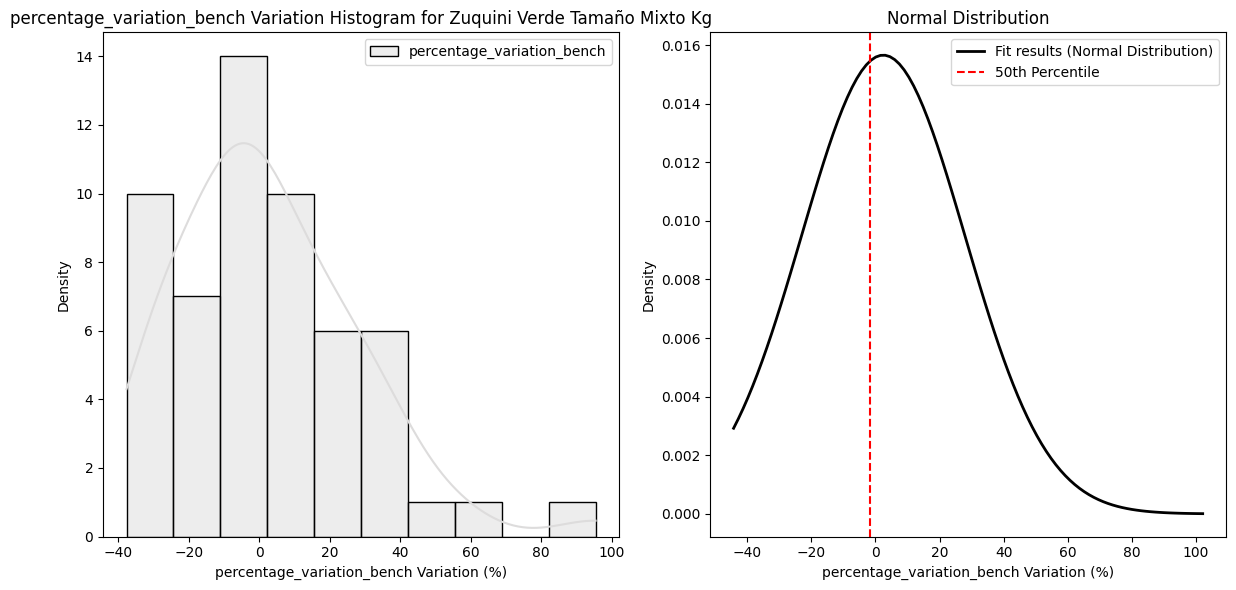

-1.0772120274894437


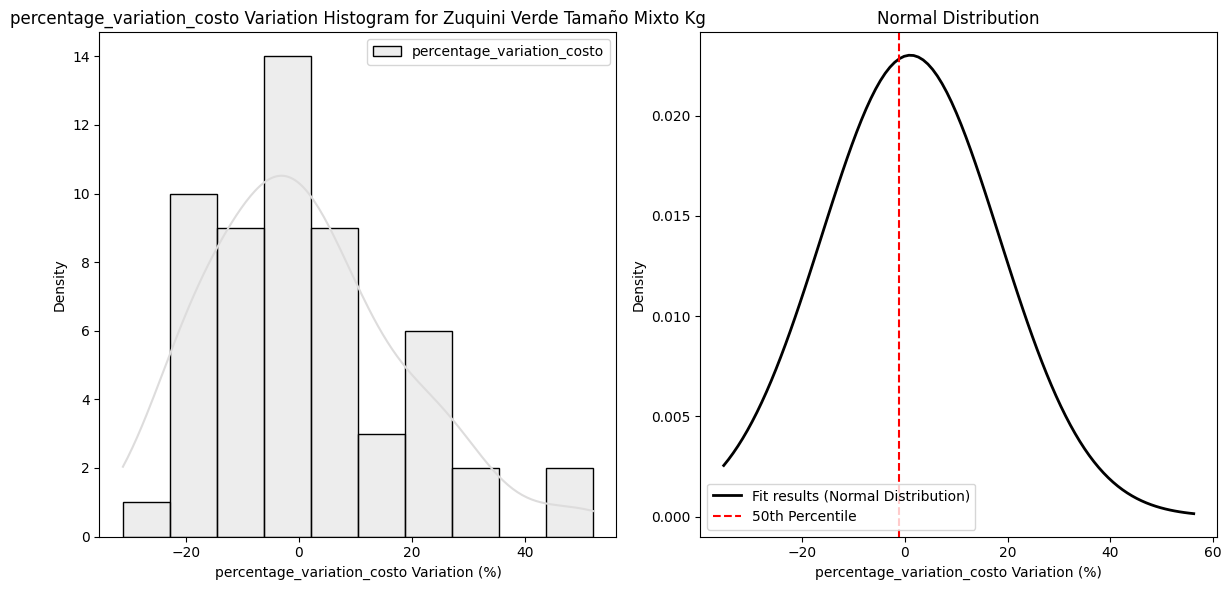

-303342
1.0096157948525808


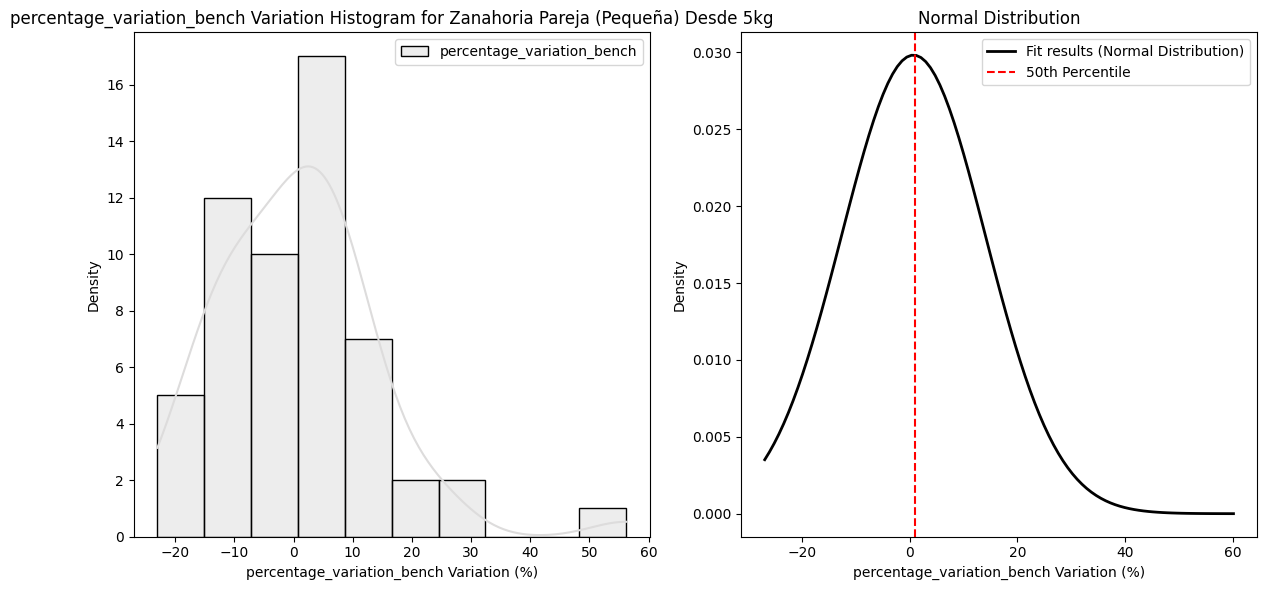

-0.9831647374025199


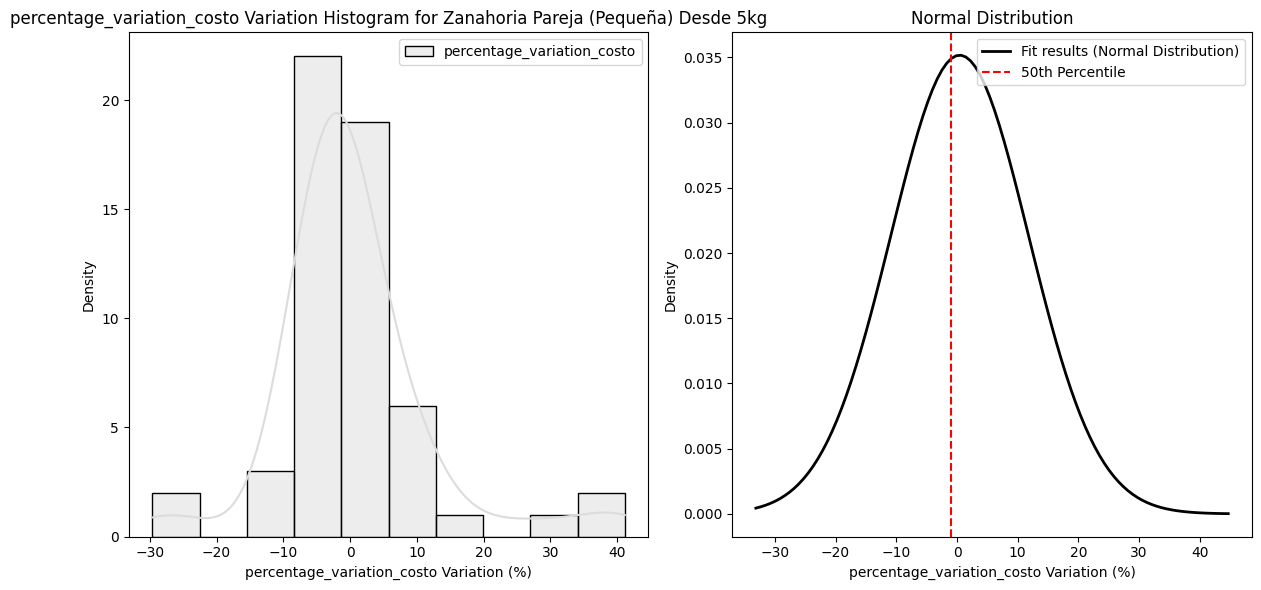

-303339
0.913274367217165


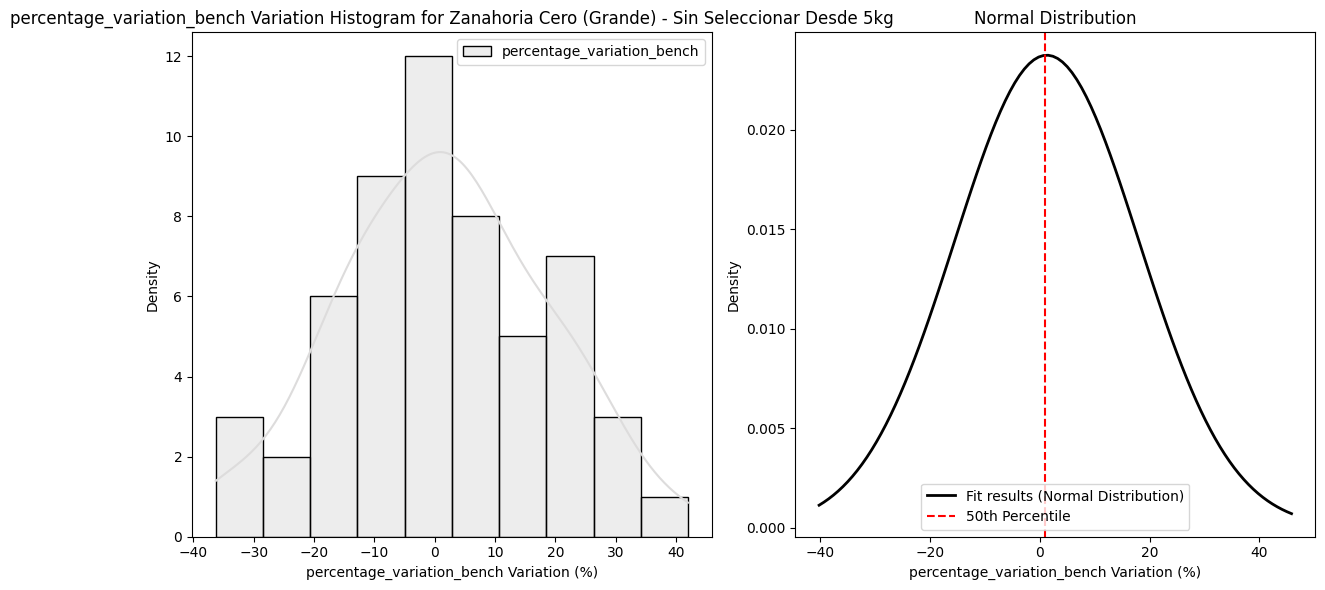

-1.9275395818130647


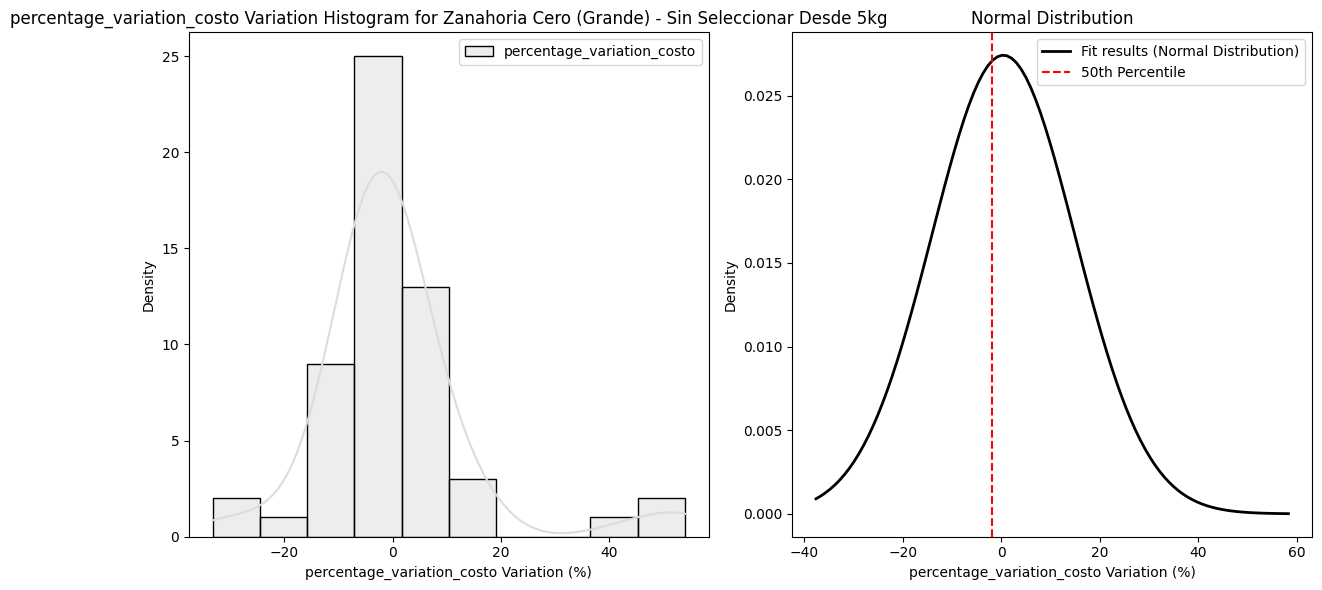

-303249
3.1057992554211378


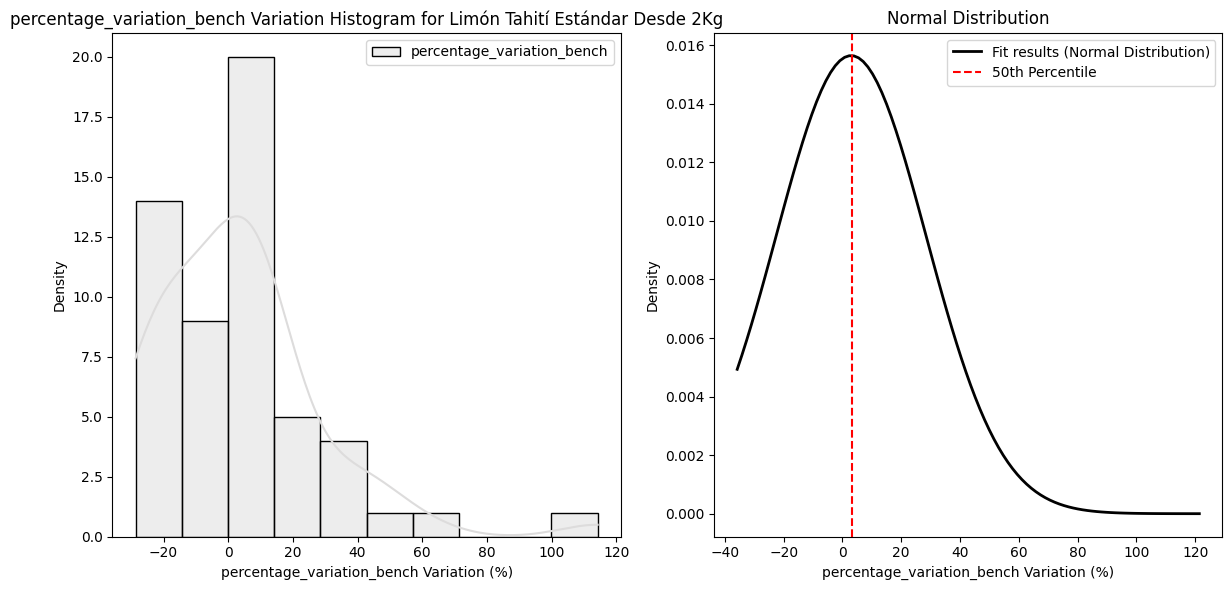

1.1096000349363644


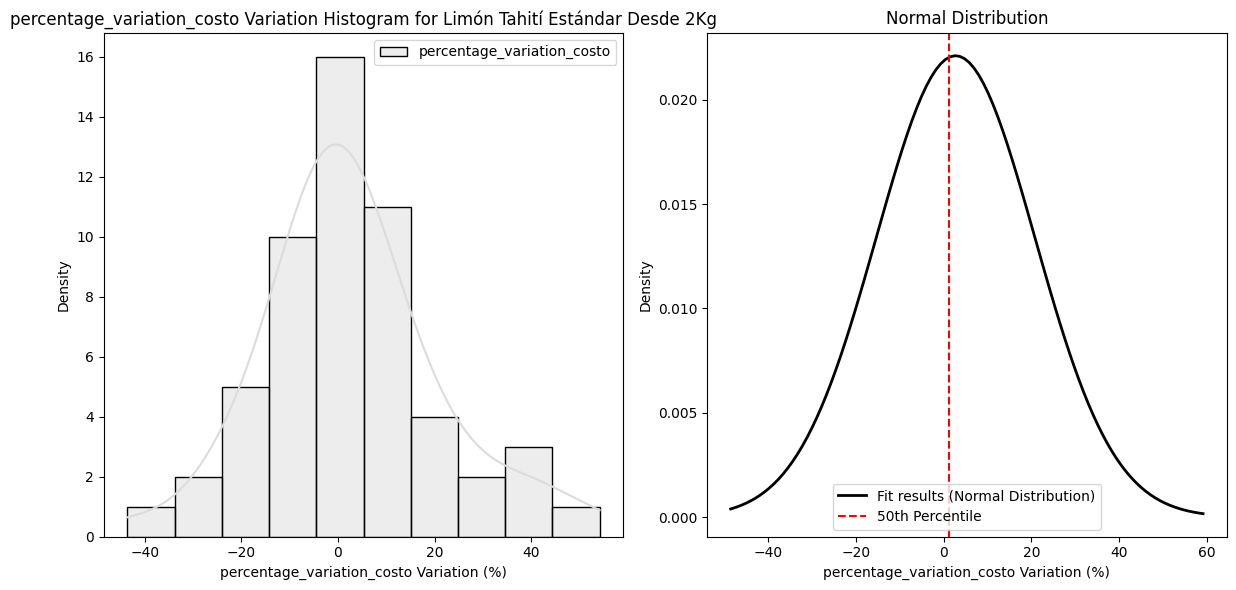

-302331
abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508983770
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073843673]
  -----------------------------------------------


Error for card_id -302331: abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508983770
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073843673]
  -----------------------------------------------


abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508989709
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073860037]
  -----------------------------------------------


Error for card_id -302331: abort query
DETAIL:  
  -----------------------------

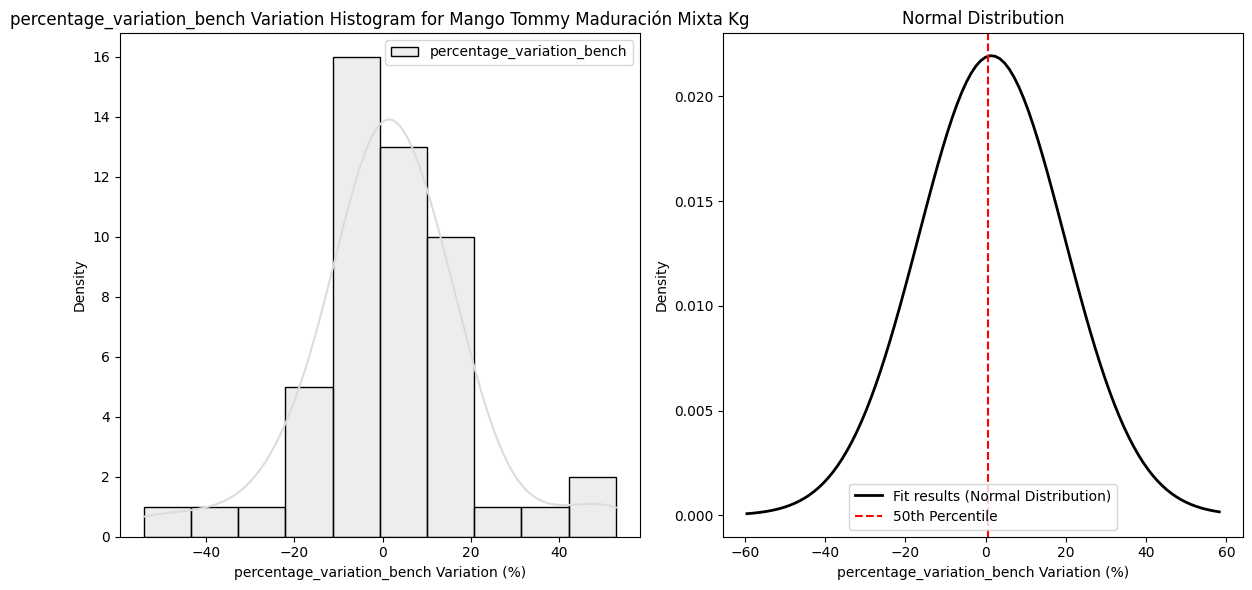

0.9115345078754222


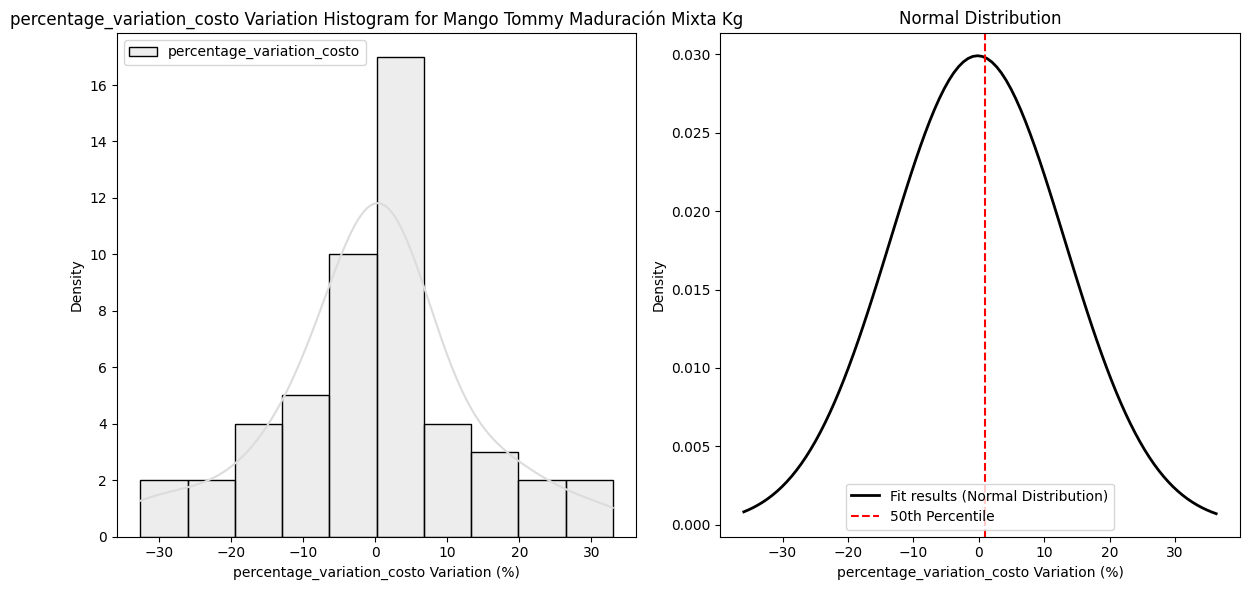

-302325
-2.718853796209919


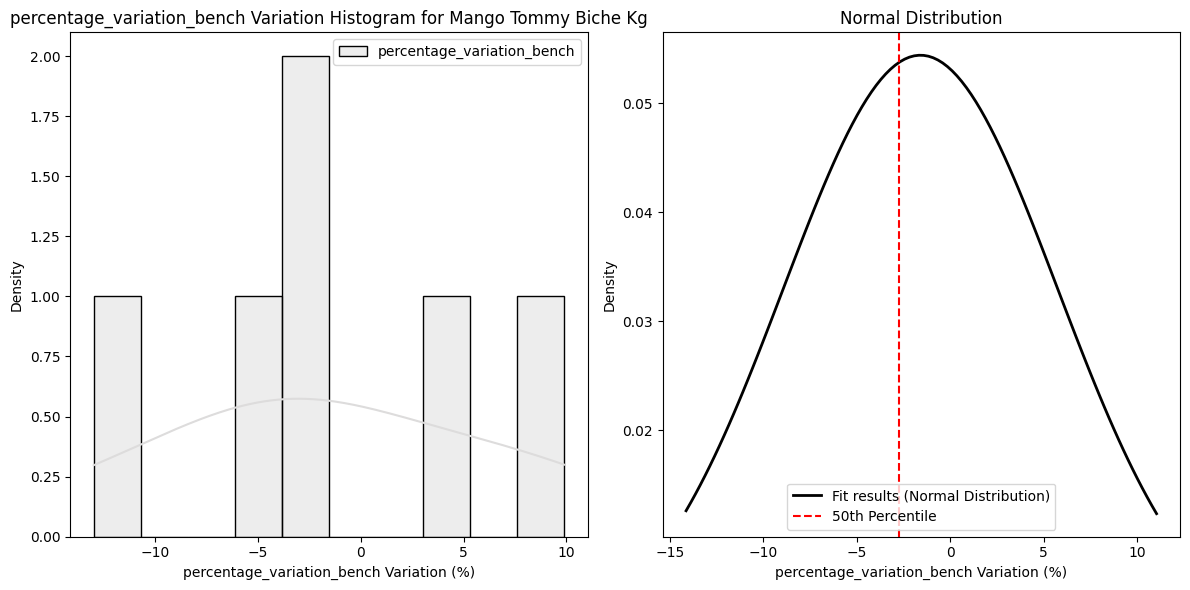

-0.09405110240063297


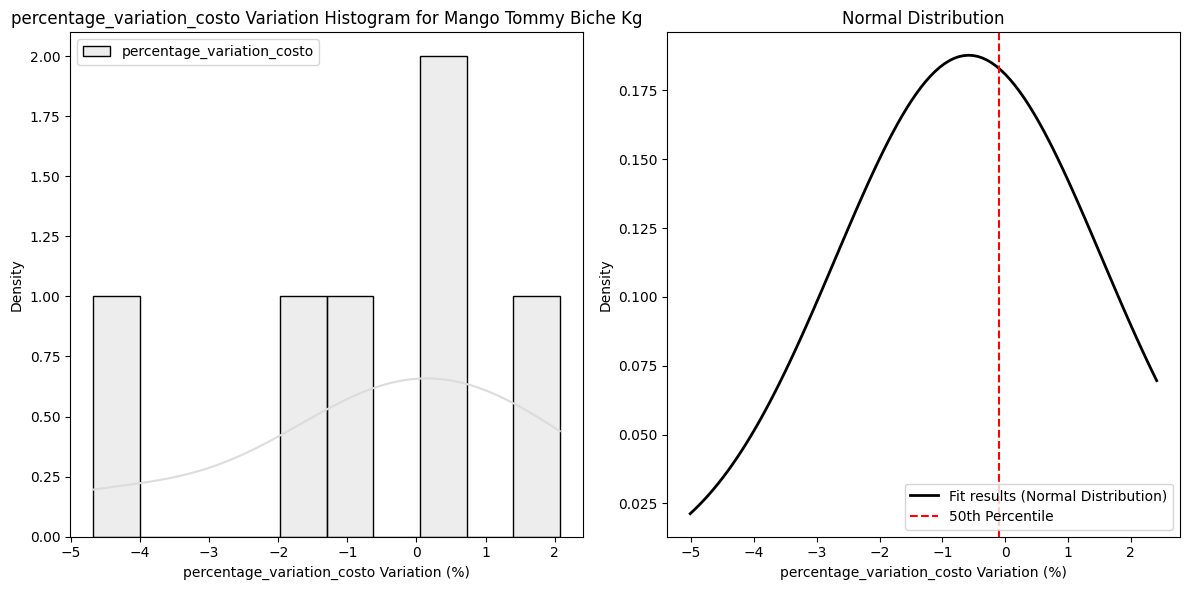

-301263
-301206
abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508996035
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073837080]
  -----------------------------------------------


Error for card_id -301206: abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508996035
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073837080]
  -----------------------------------------------


abort query
DETAIL:  
  -----------------------------------------------
  error:  abort query
  code:      1020
  context:   system requested abort
  query:     508998578
  location:  queryabort.hpp:89
  process:   padbmaster [pid=1073998697]
  -----------------------------------------------


Error for card_id -301206: abort query
DETAIL:  
  ---------------------

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0, flags=flags)


-2.4915494361083477


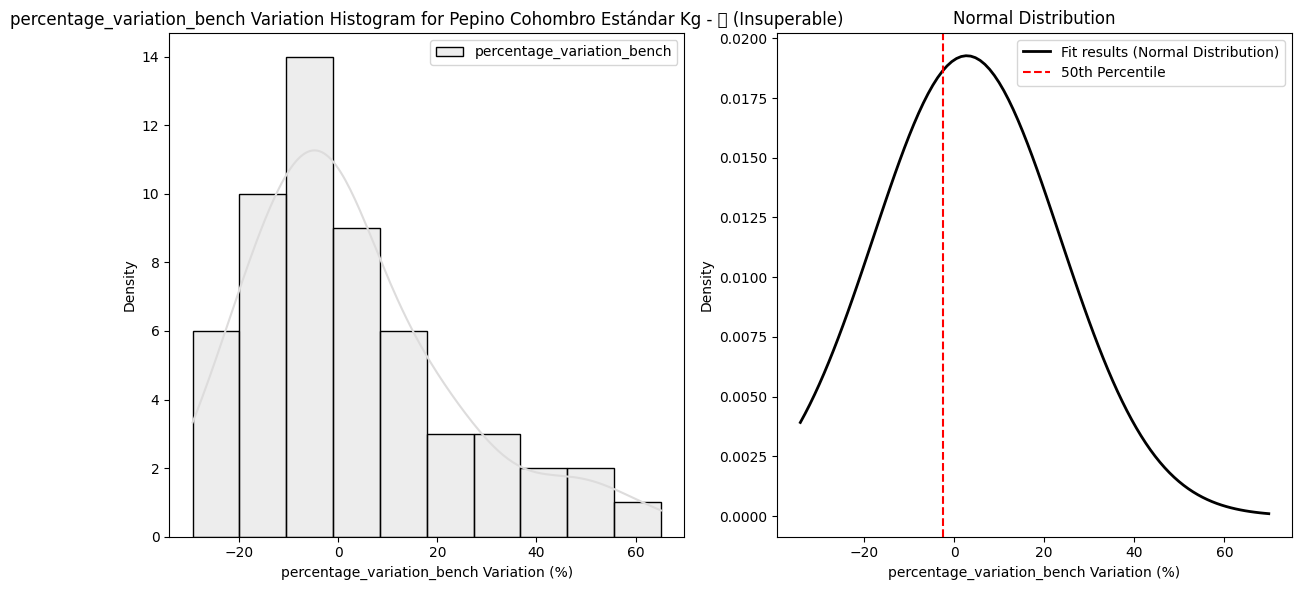

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0, flags=flags)


0.2592534074217834


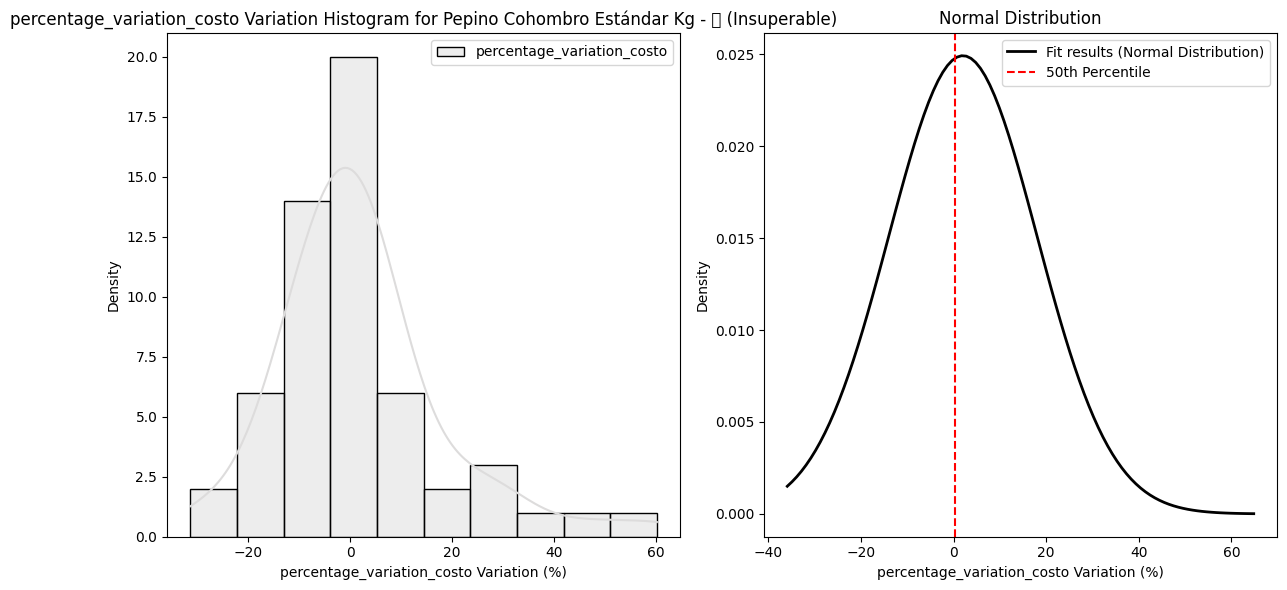

-301131
0.05172906952549128


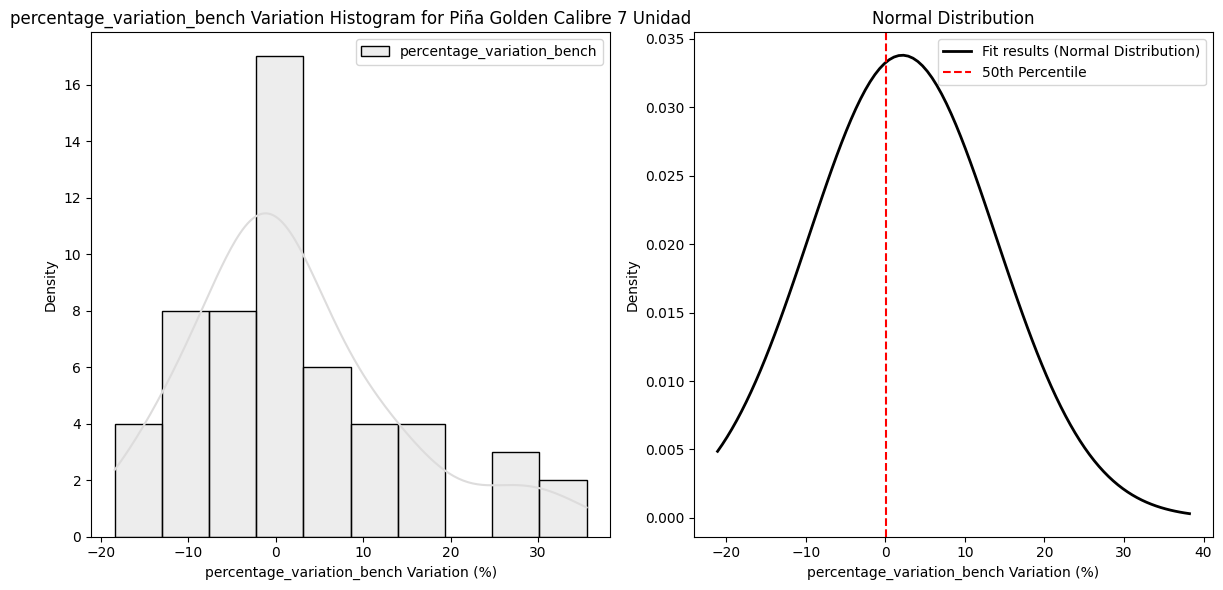

0.9457860143331831


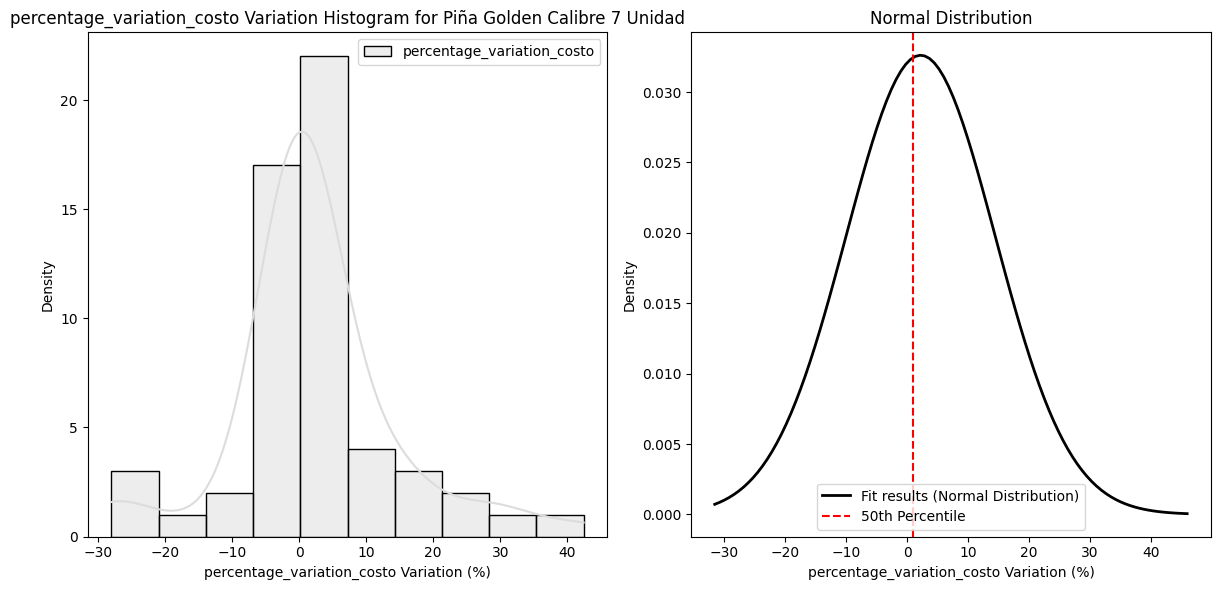

-300165


/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0, flags=flags)


-3.4229222967519677


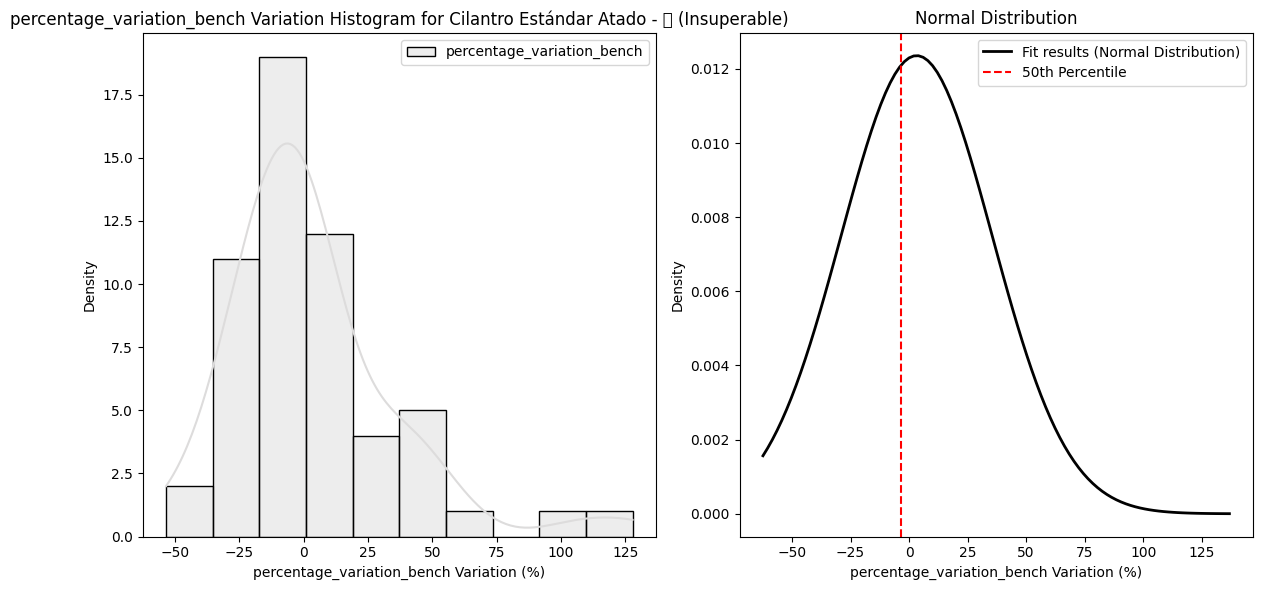

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129297 missing from current font.
  font.set_text(s, 0, flags=flags)


-2.8229442239135425


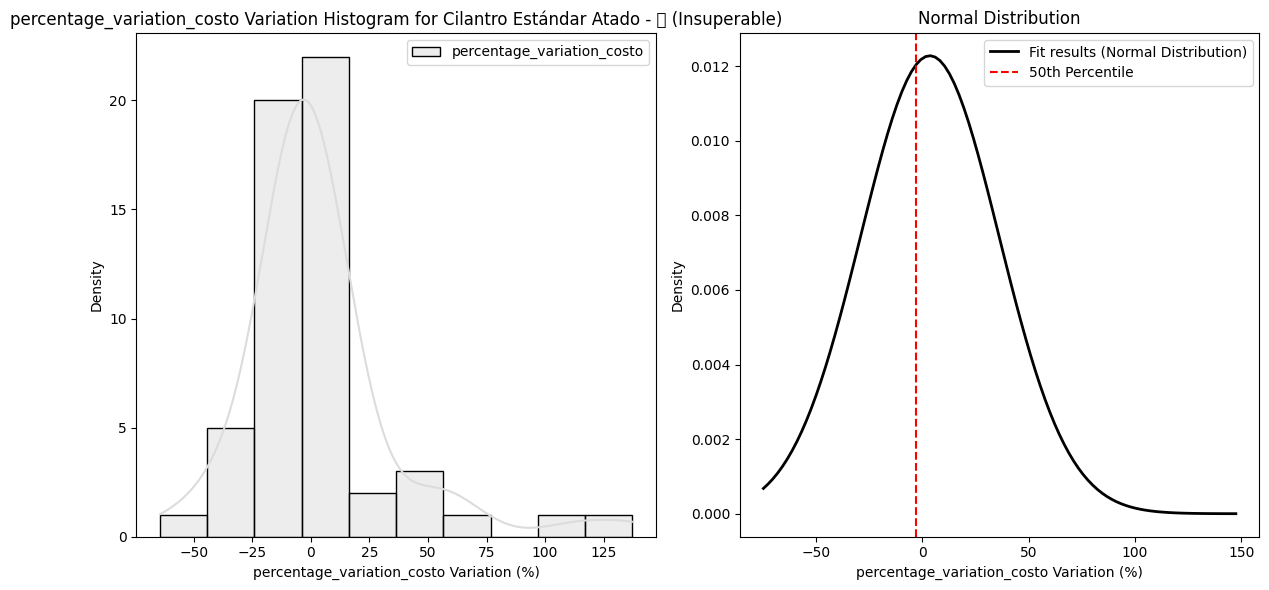

60433


/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0, flags=flags)


-0.13905043898130298


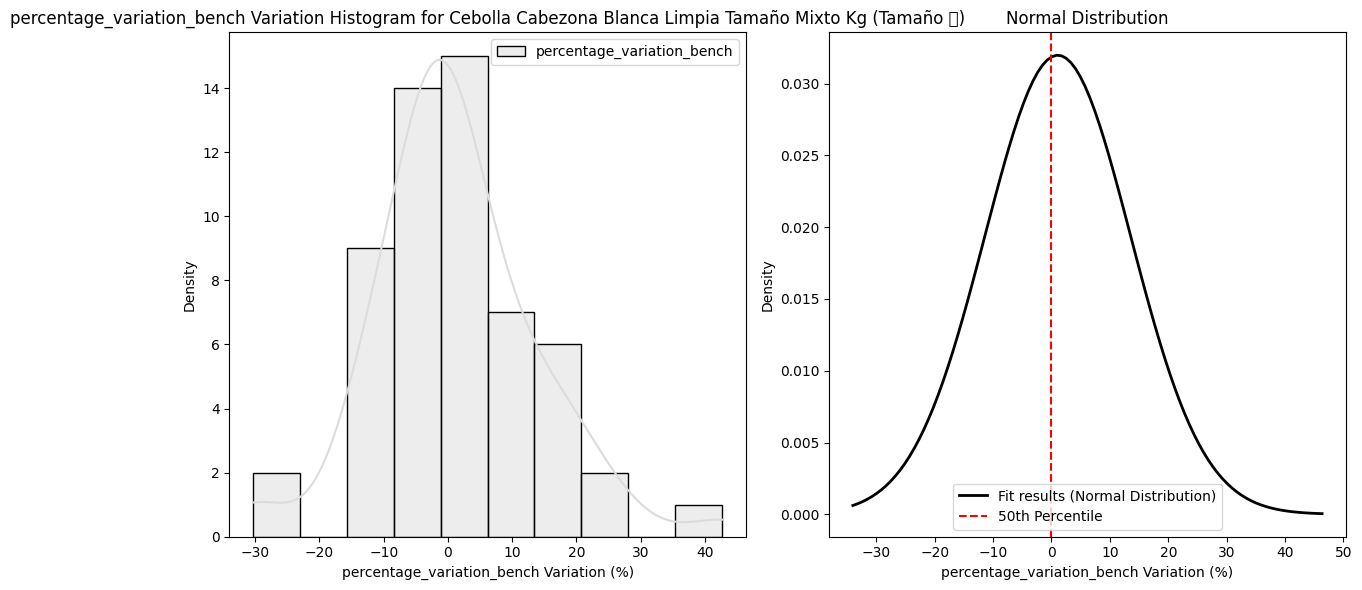

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0, flags=flags)


-0.6226792332058639


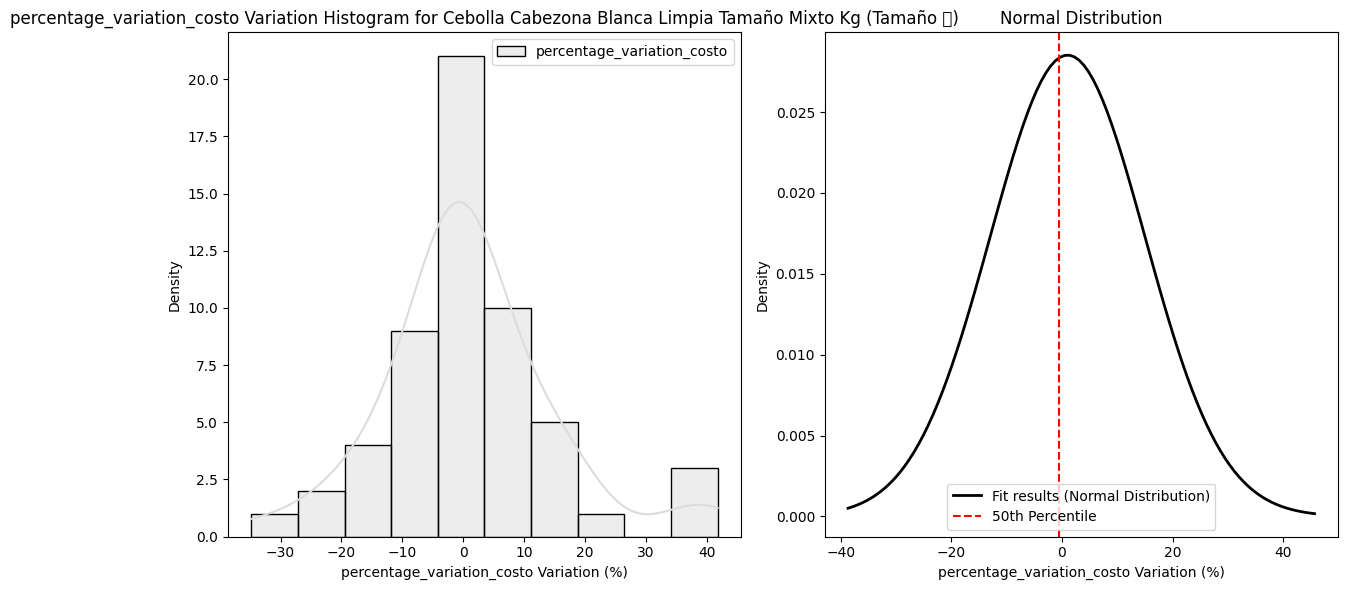

60592


/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0, flags=flags)


-3.9467336445794423


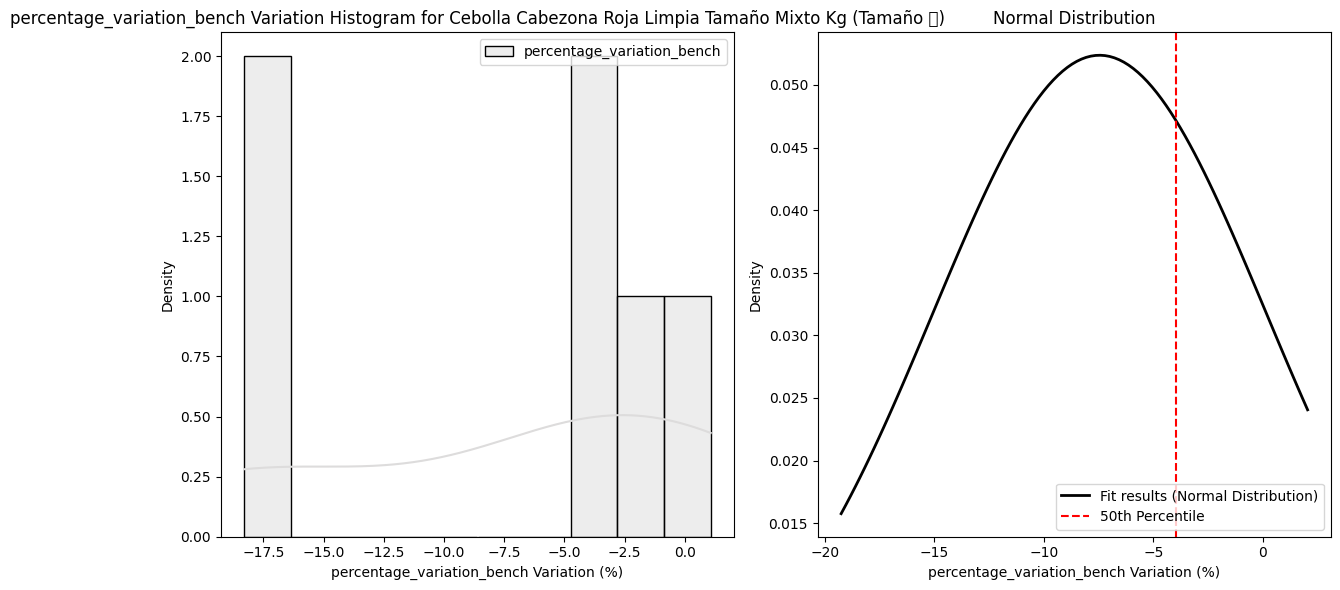

/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127968 missing from current font.
  font.set_text(s, 0, flags=flags)


-5.157174076506289


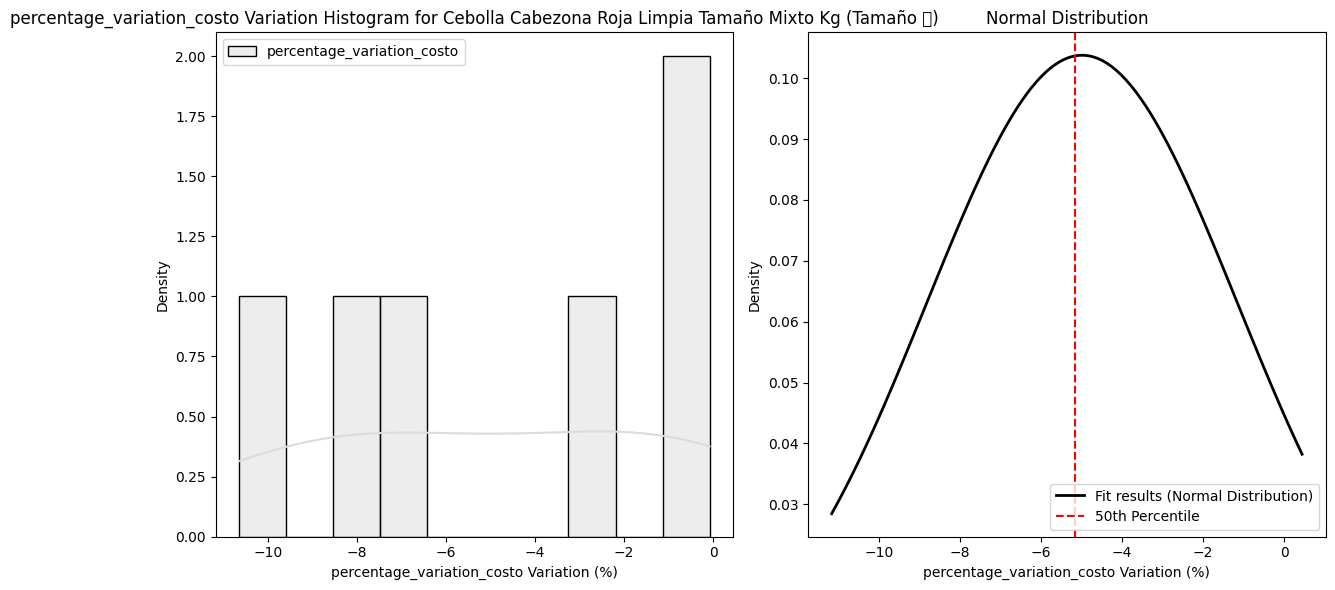

144878
0.3212596787066535


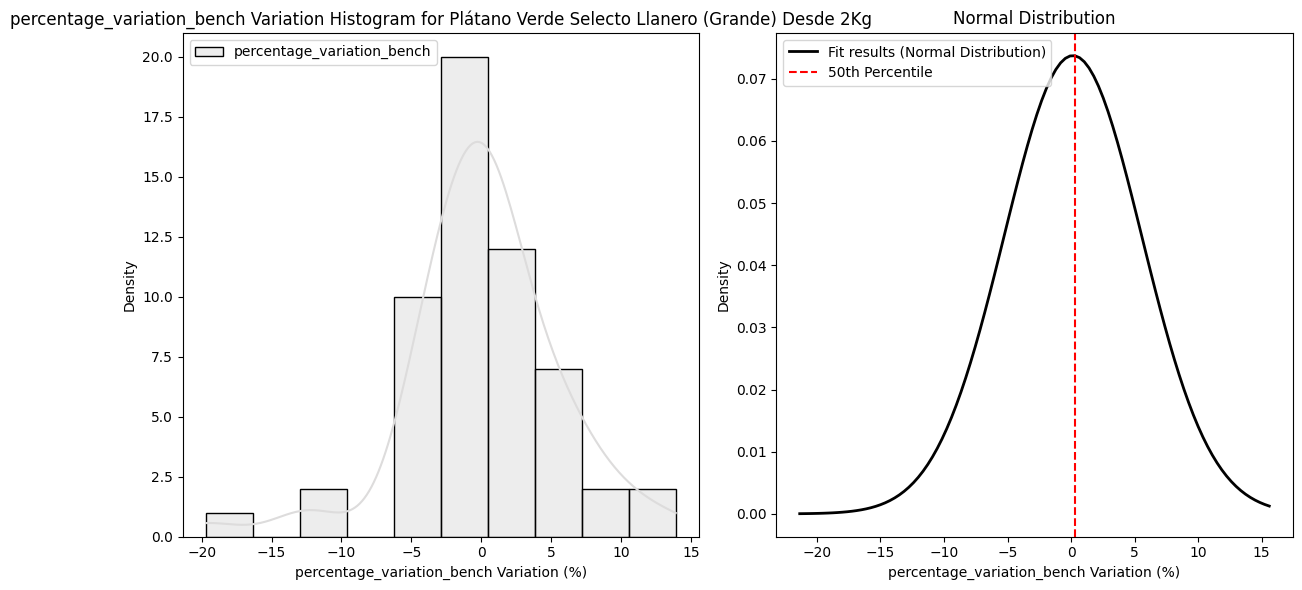

-0.3358216937319636


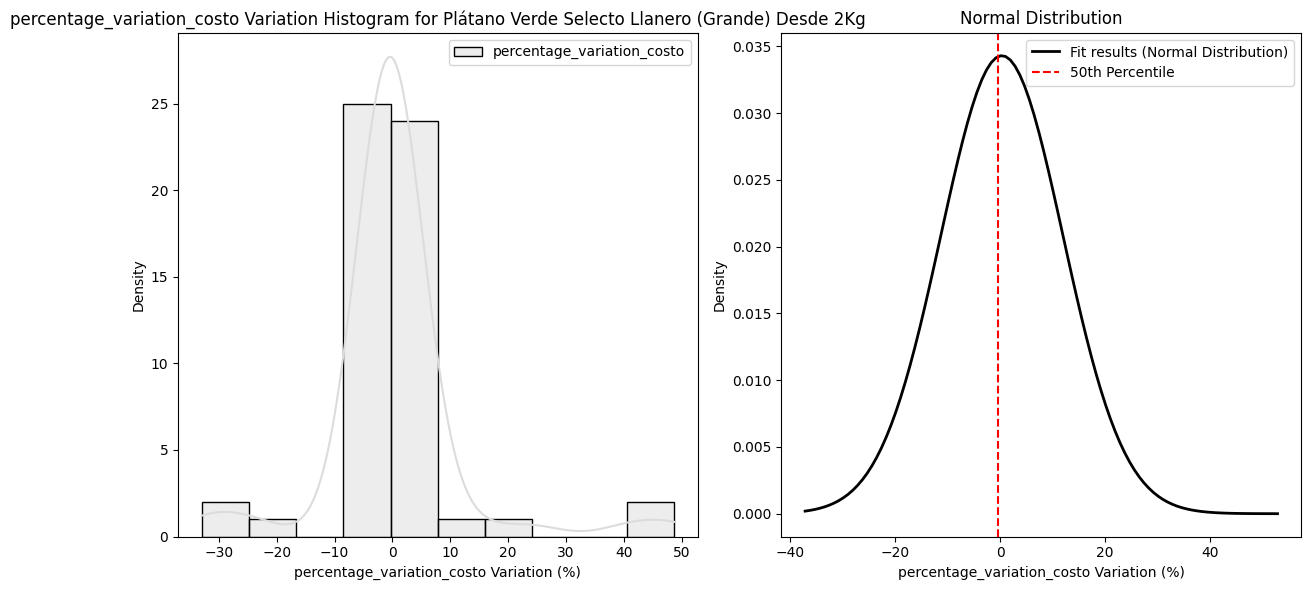

144882
-0.5984839553904775


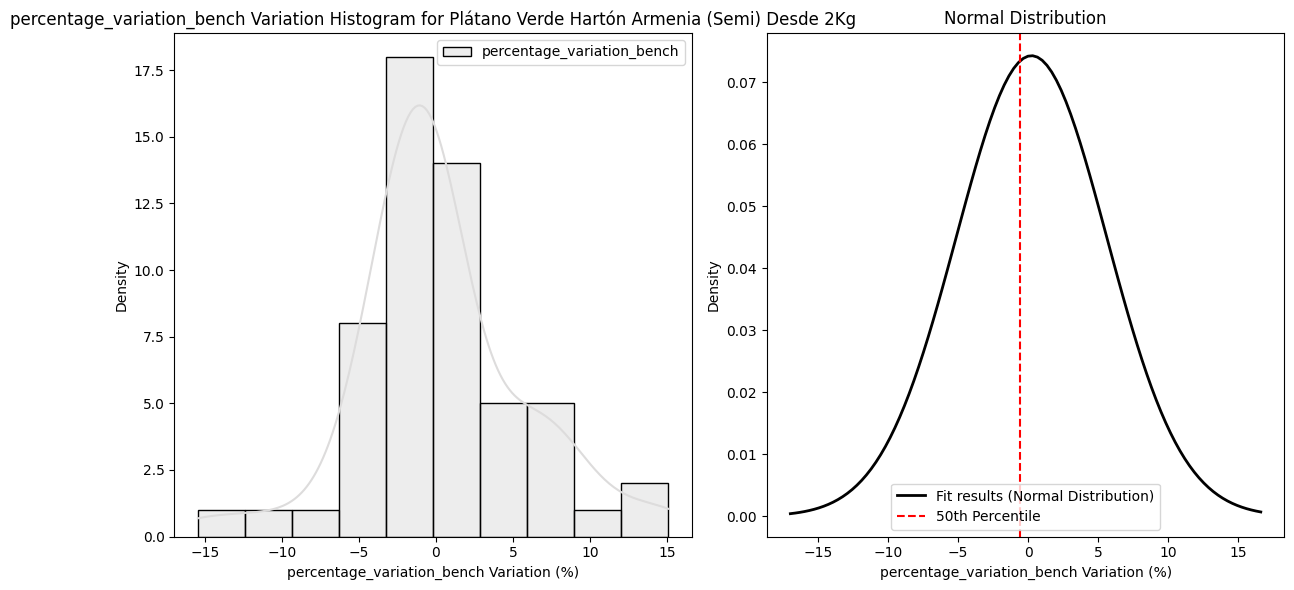

-0.12100111648744583


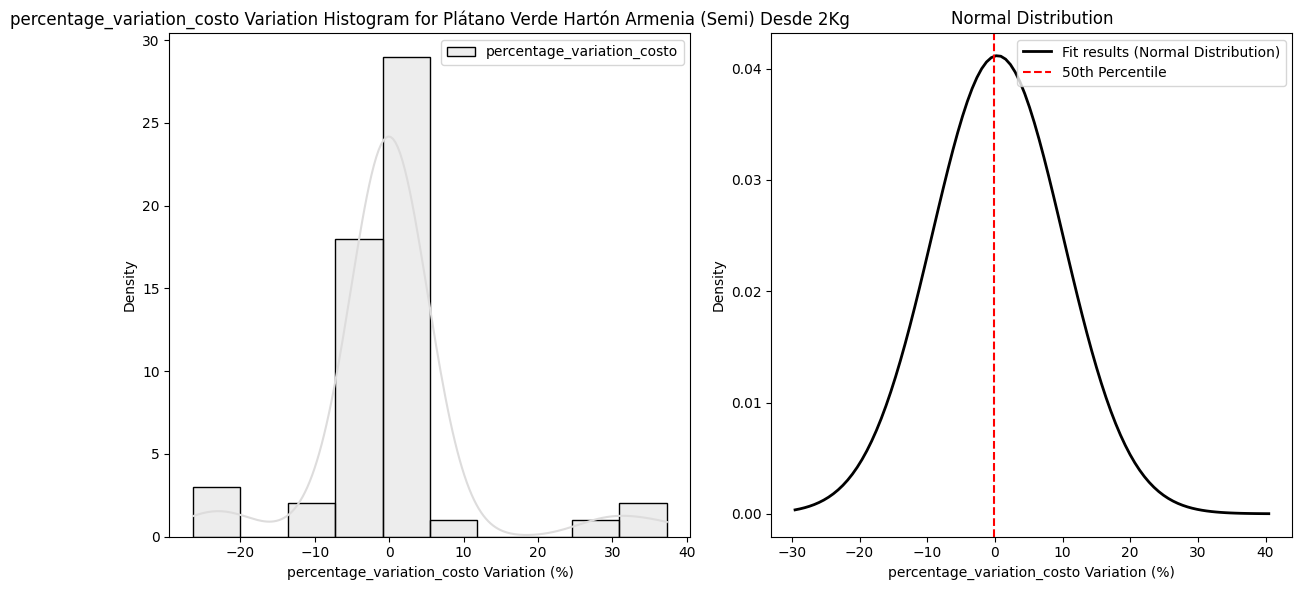

144886
-0.4003504998866314


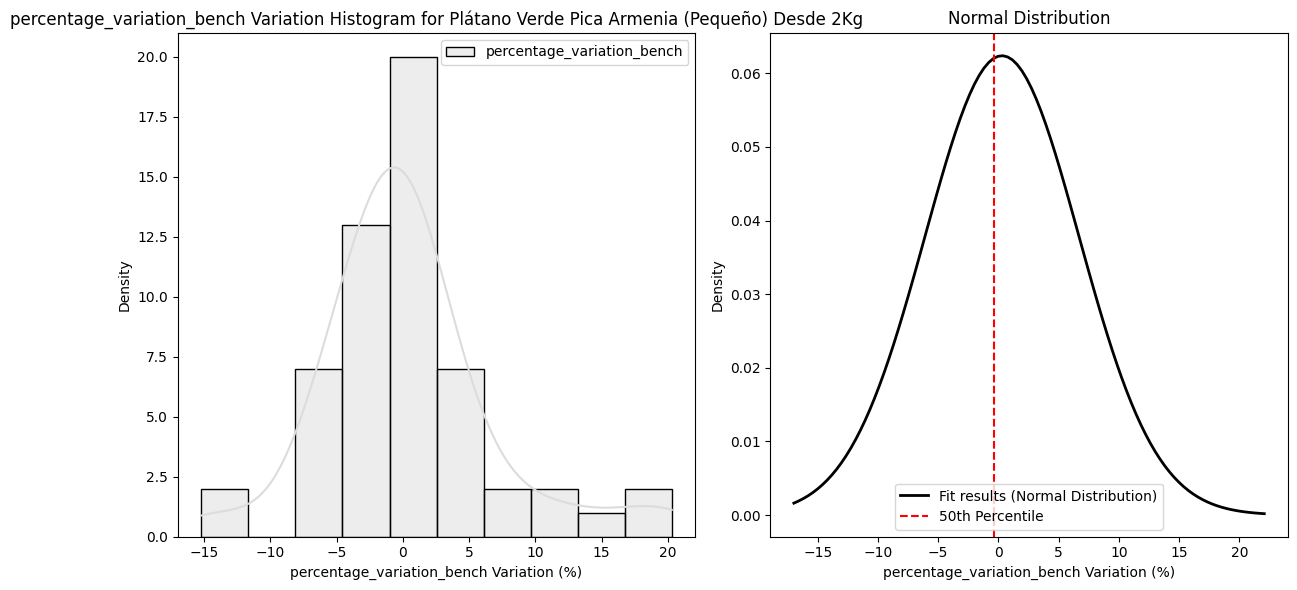

-0.0020330207140206724


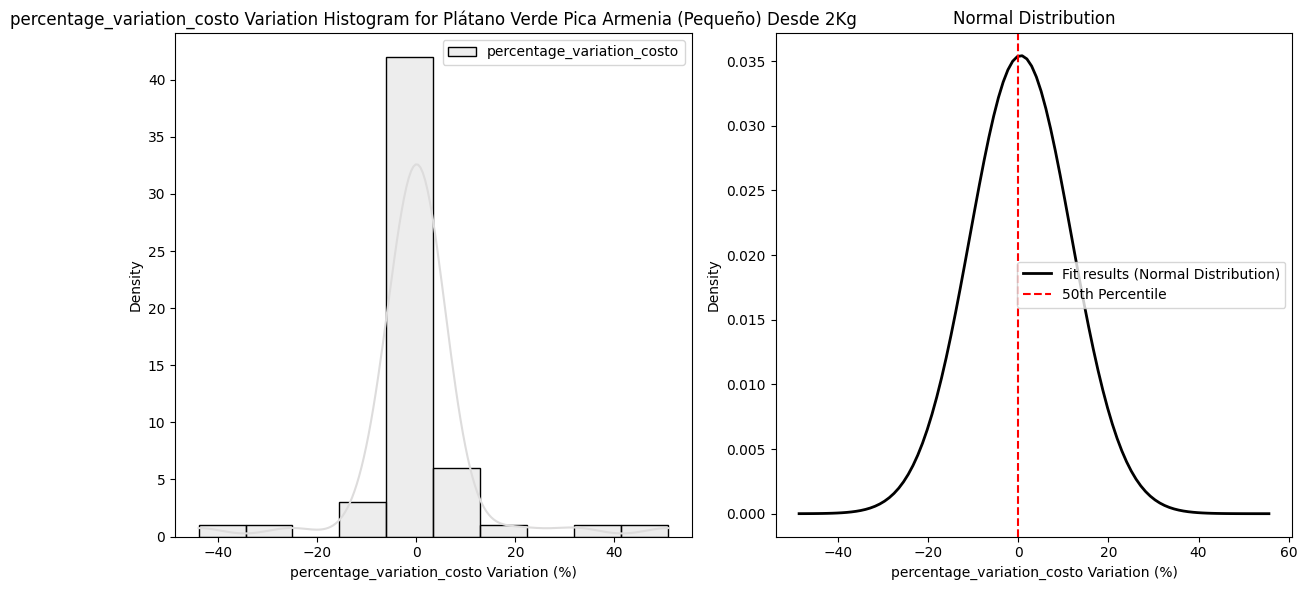

144920
0.05749717508679586


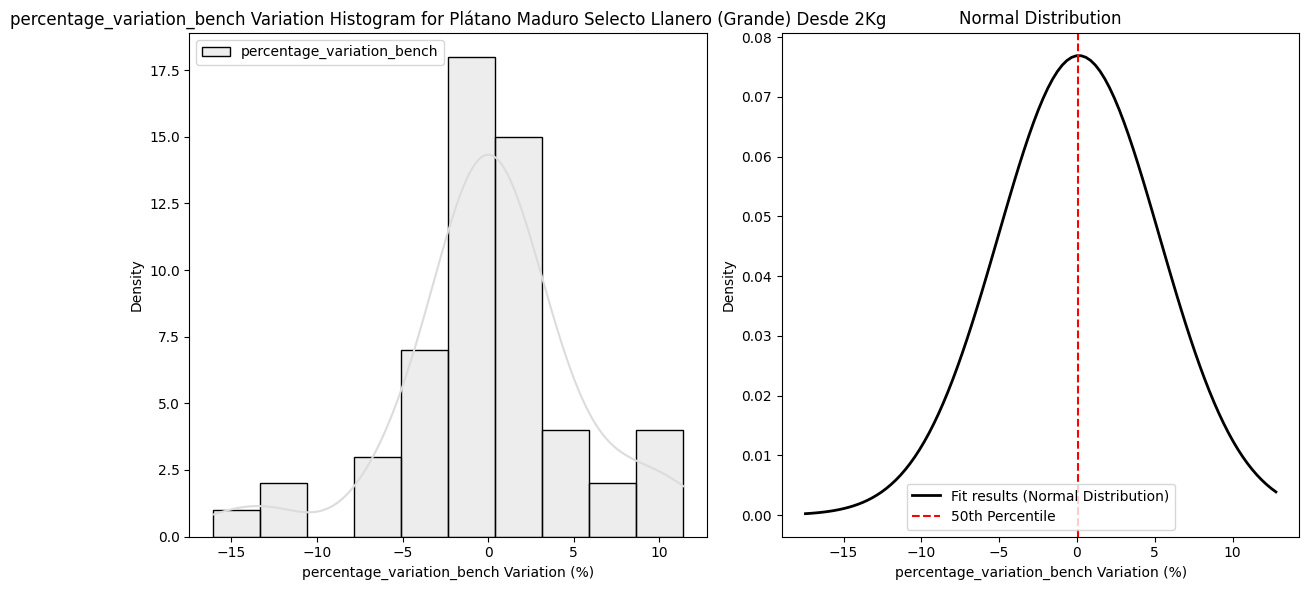

-0.10876007830245005


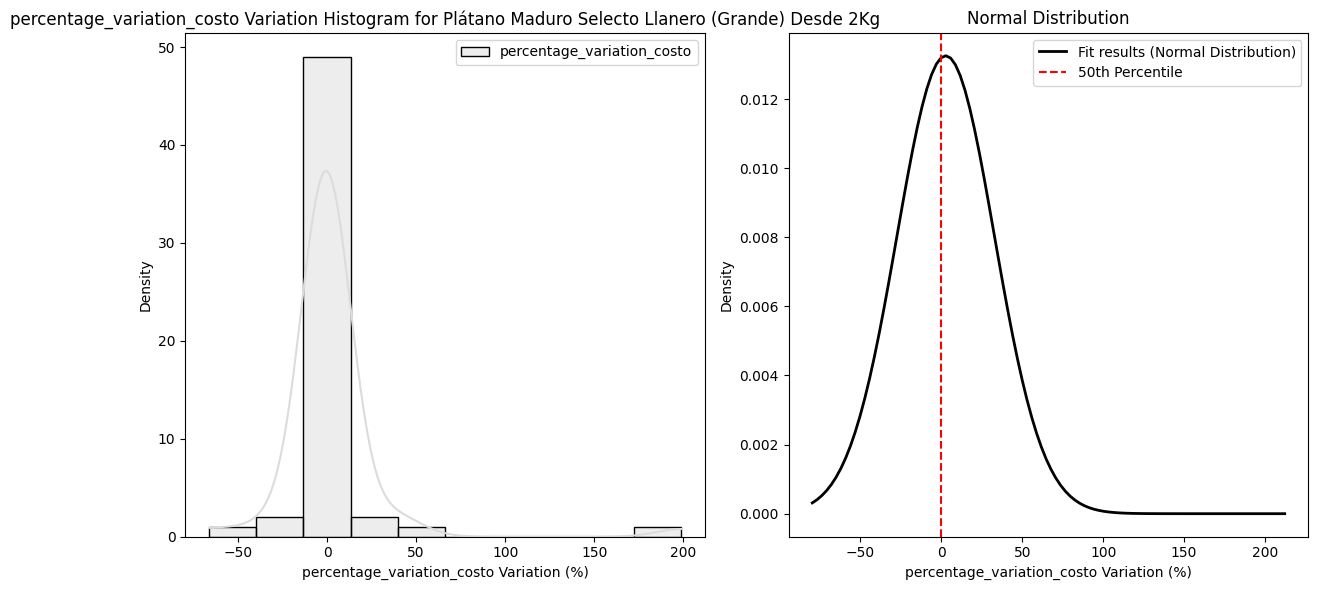

144924
-0.1312996873381489


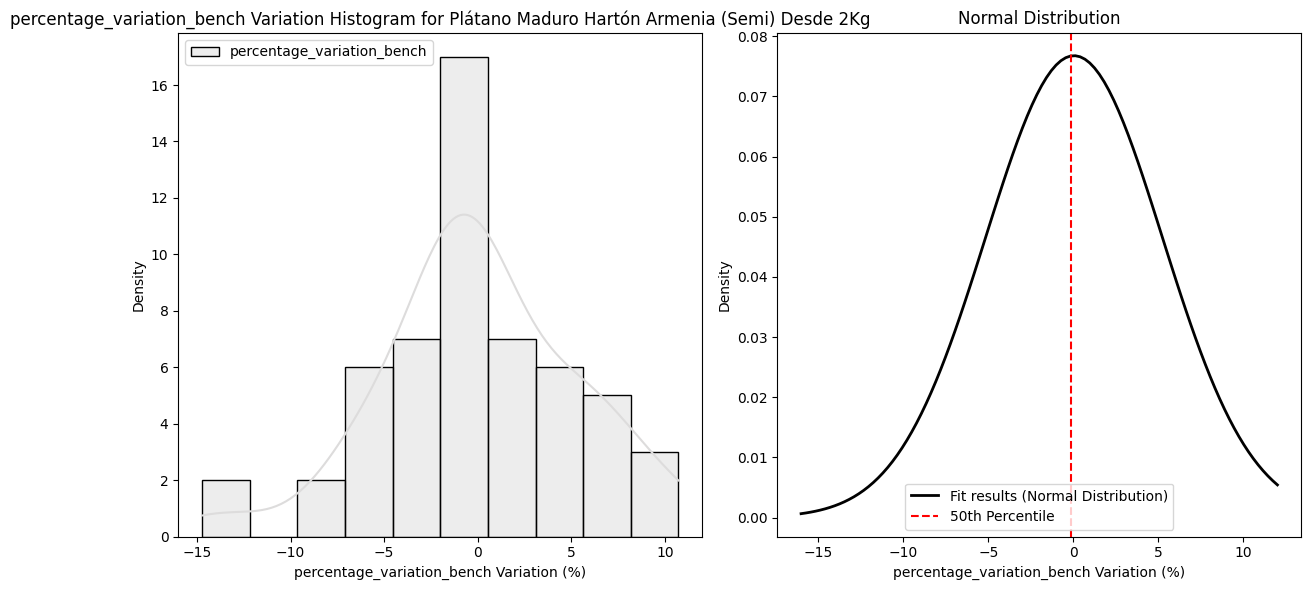

-0.1727740257685073


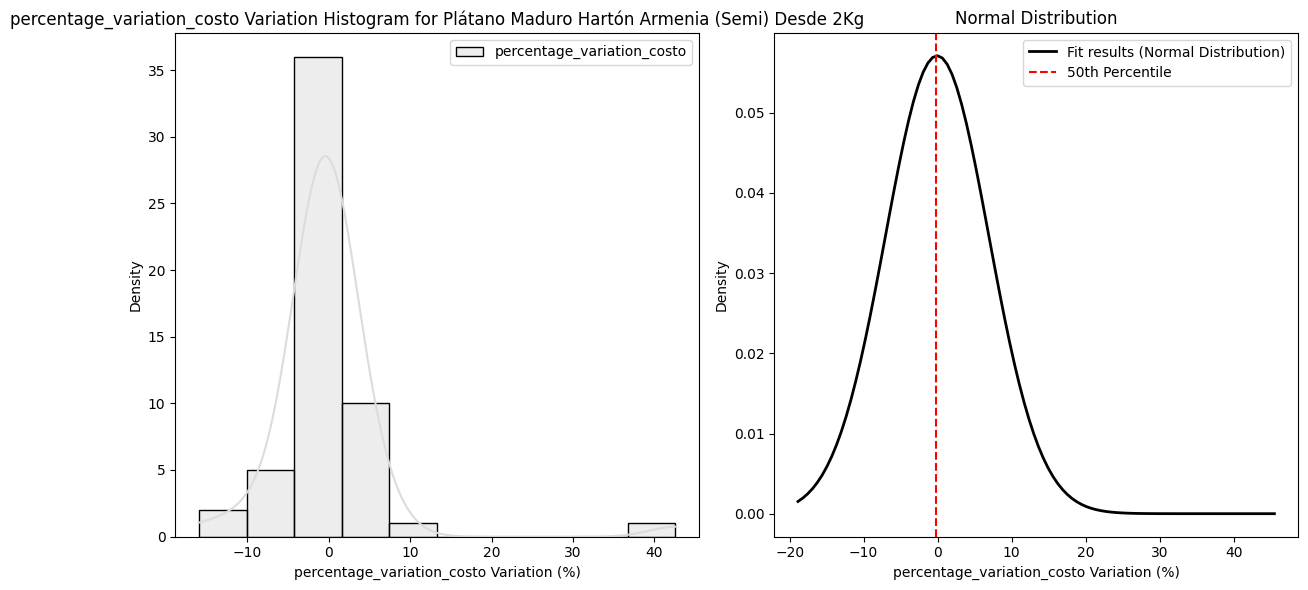

144936
0.0


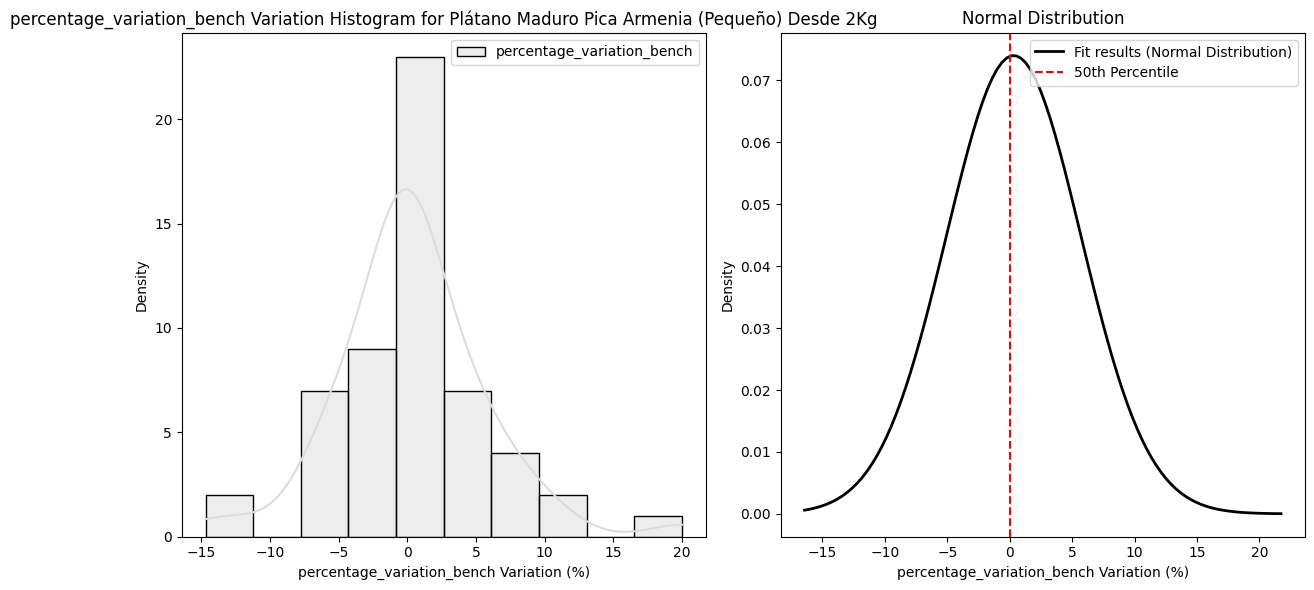

-0.5701898233935299


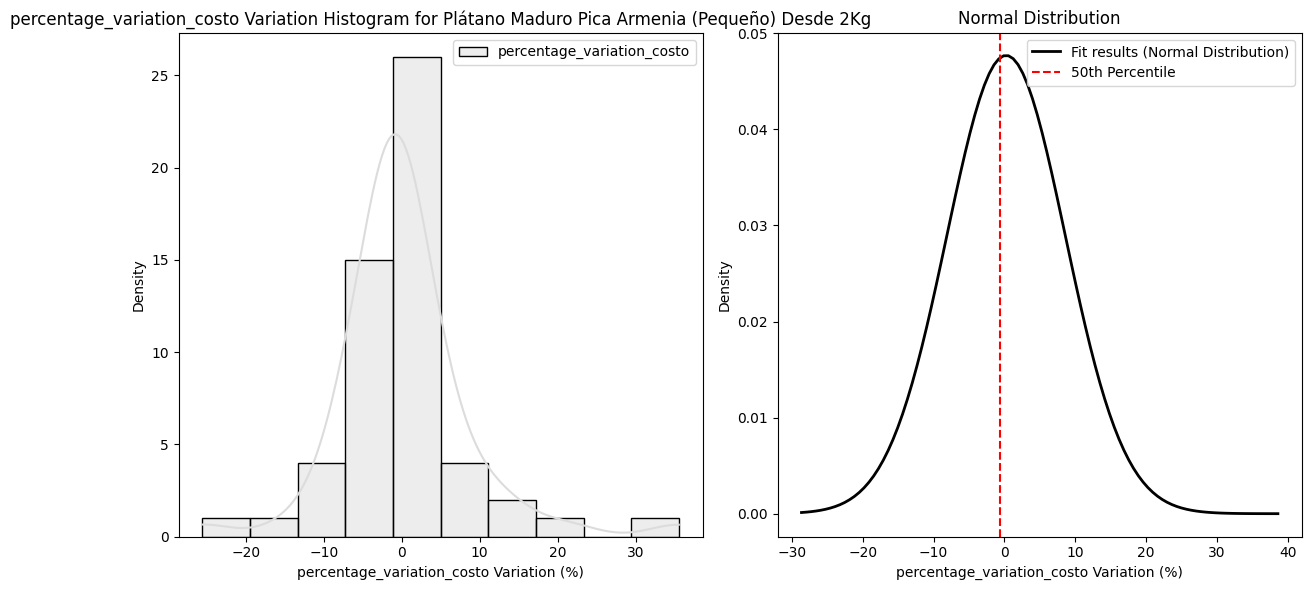

556151
1.7136167862106366


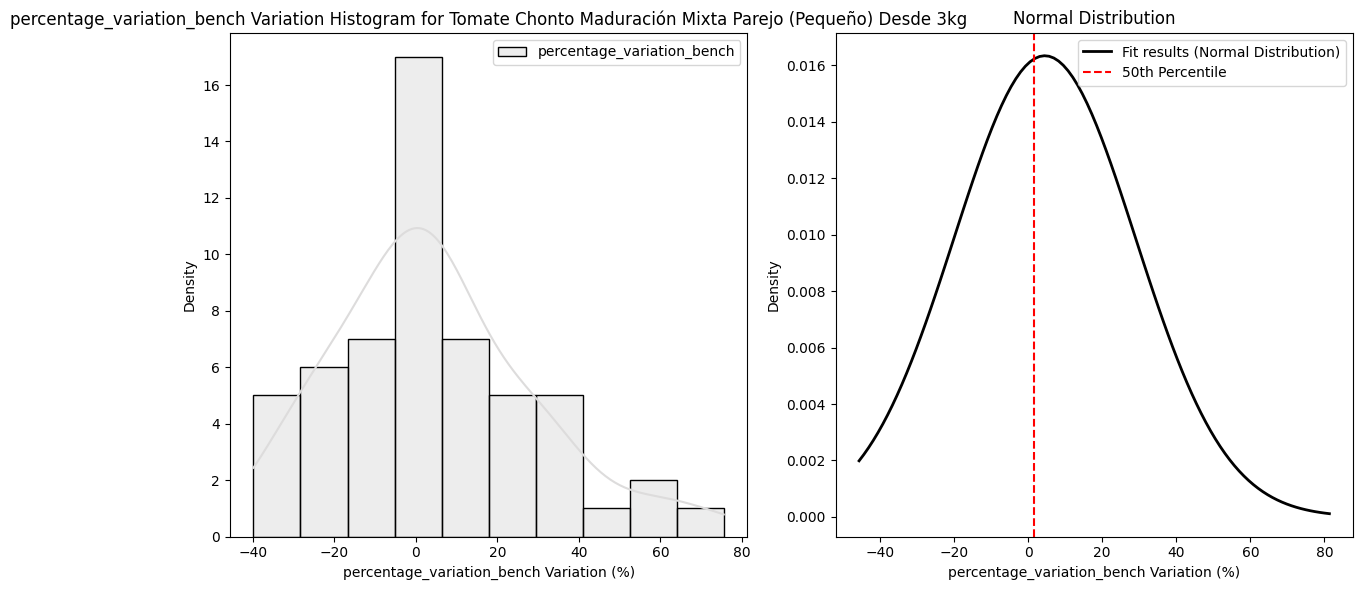

0.9999276846597405


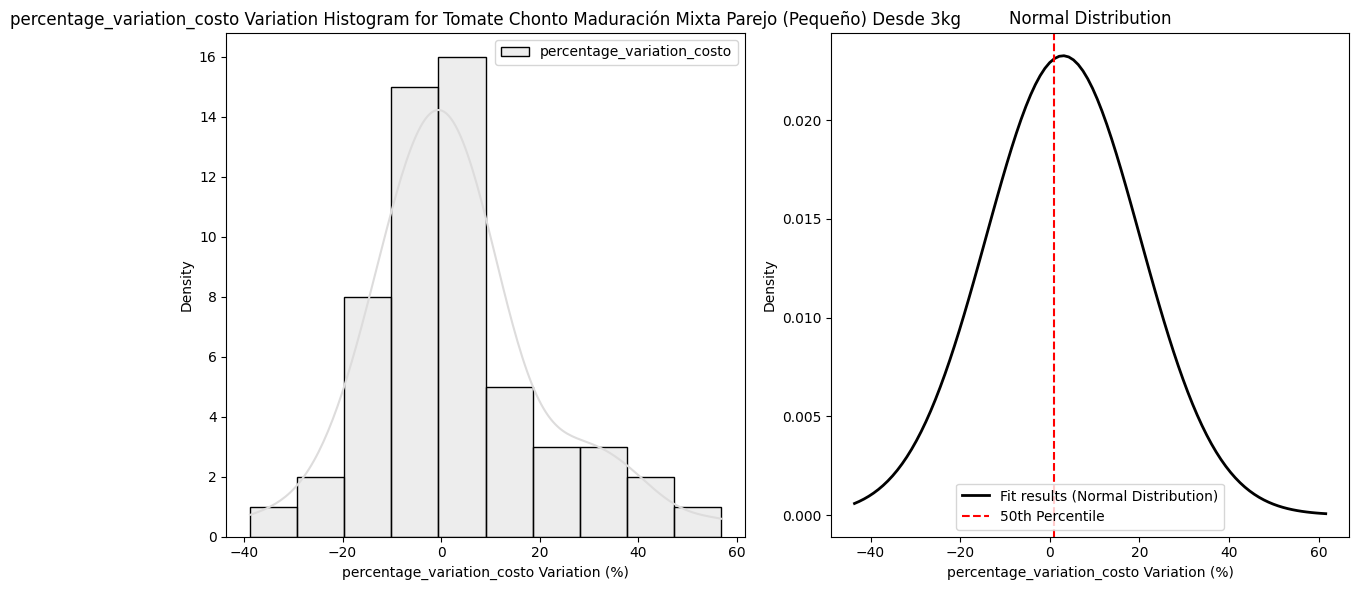

556152
0.44964755159493386


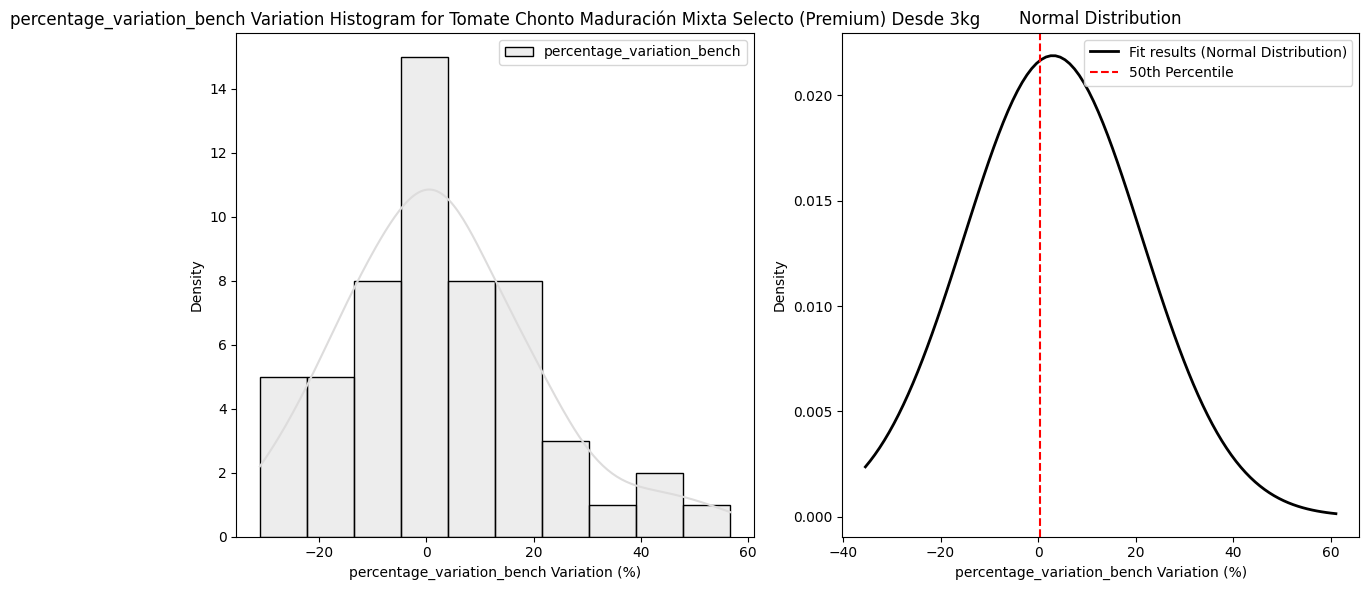

0.15031709669095505


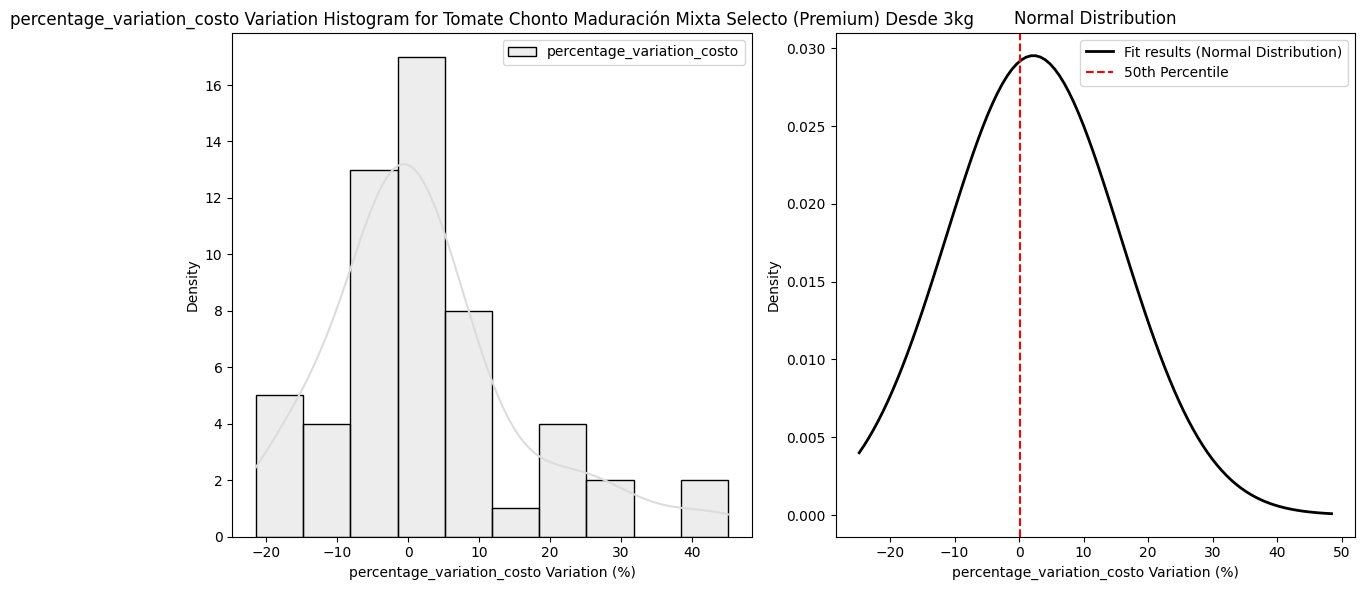

556153
1.240840088878714


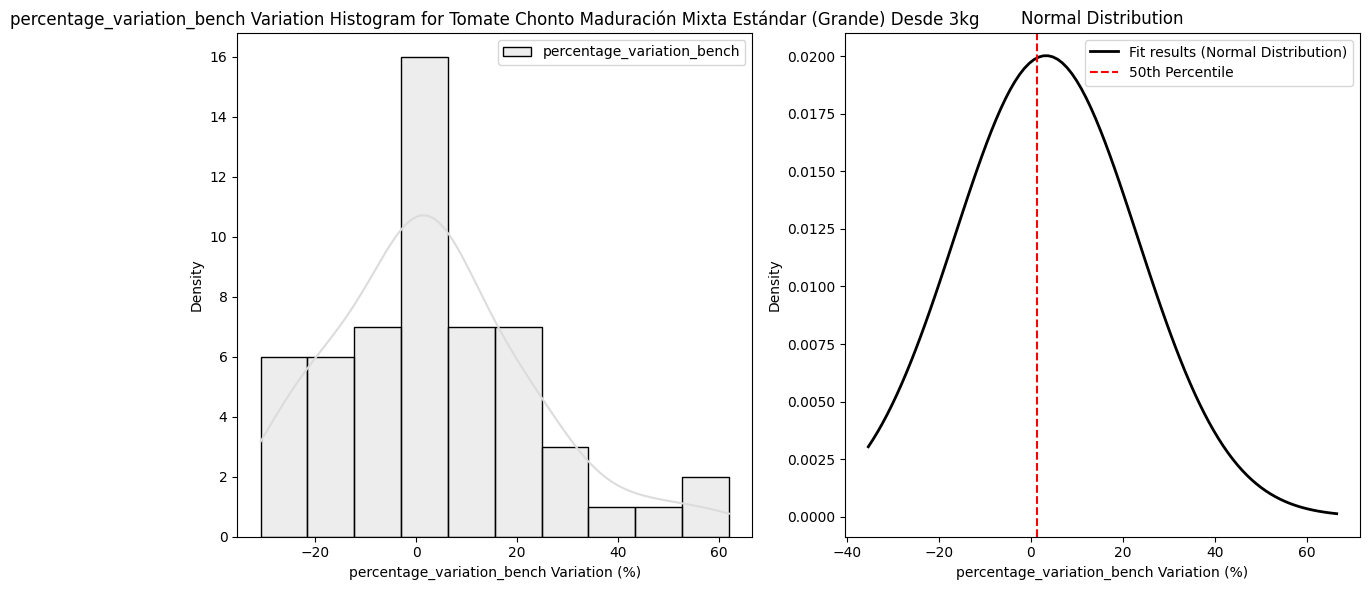

0.10521371638874677


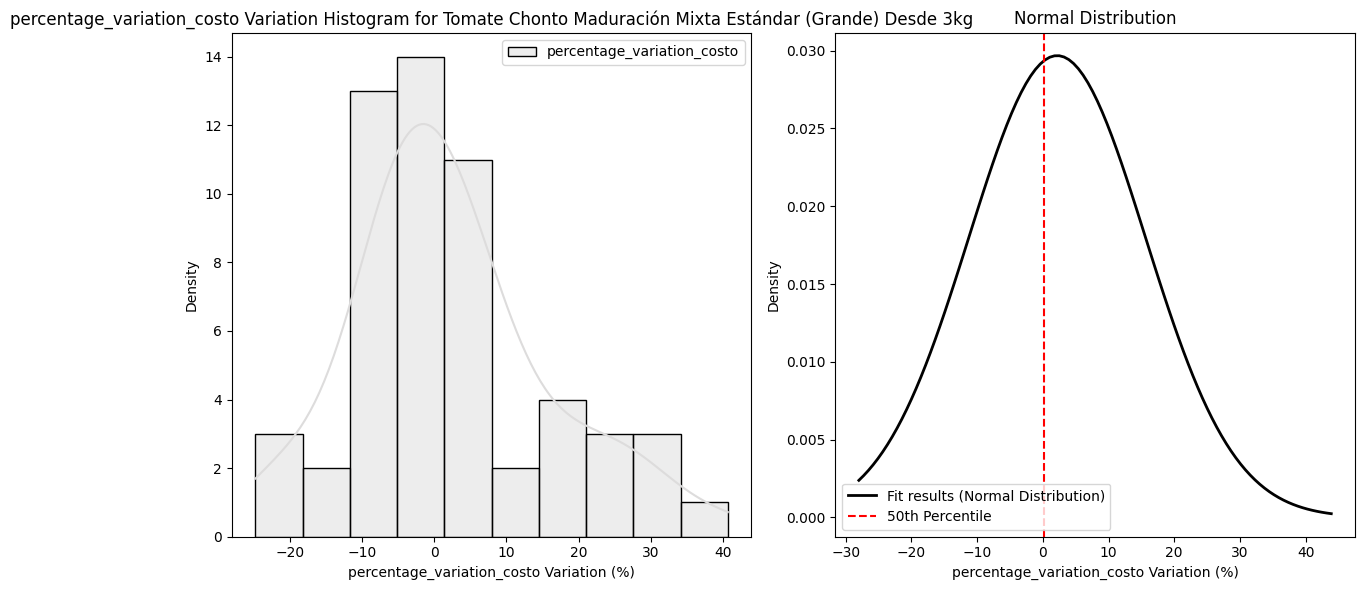

In [23]:
# Create an empty list to store dictionaries
data_list = []

for card_id in info.card_idd.unique():
    print(card_id)
    if card_id == -301263:
        pass
    else:
        success = False
        while not success:
            try:
                df_cost = historic(card_id)
                percentil_bench = 50
                bench = plot_pairplot(df_cost, card_id, 'percentage_variation_bench', percentil_bench)

                percentil_costo = 50
                costo = plot_pairplot(df_cost, card_id, 'percentage_variation_costo', percentil_costo)

                # Append a dictionary with the data to the list
                data_list.append({'card_id': card_id, 'costo': costo, 'bench': bench})
                success = True  # Break the loop if the query is successful
            except Exception as e:
                print(f"Error for card_id {card_id}: {e}")
                # Handle the error as needed (logging, etc.)
                pass
result_df = pd.DataFrame(data_list)

In [24]:
result_df.to_excel('valueskam4.xlsx')